# Linear Regression

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as sta
ts
import pickle


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFECV


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

**Before I do anything, I will load the cleaned test and train dataframes.**

In [2]:
with open('indians.pickle','rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

## One-Hot encoding

**Before making the first version of the linear regression model, I will write a function that one-hot encodes all categorical columns of the input dataframe. Furthermore, if the 'no_of_dwelling_rooms' (the only numerical column) is in the input dataframe, it will be feature scaled to have values between 0 and 1. The reason for that is that the categorical values will become 1 and 0 and thus the 'no_of_dwelling_rooms' variable would become too powerful without feature scaling.**

In [3]:
def normalize_0_1(col):
    return (col - col.min())/(col.max()-col.min())

def make_dummies(df, one_hot = True):
    if 'district' in df.columns:
        df.district = df.district.astype(str)
    df = pd.get_dummies(df, drop_first=one_hot)
    if 'no_of_dwelling_rooms' in df.columns:
        df.no_of_dwelling_rooms = normalize_0_1(df.no_of_dwelling_rooms)
    return df

## Error Metric

**I'll build a model that aims to predict the age a person dies ('lifetime') from the household he is part of. There are countless factors that have nothing to do with the household somebody is part of which influence a persons age of death. There are also completely random events that can drastically shorten a person's life. The chance to die by being run down by a car for example does not depend on somebody's household for example. For those reasons, the model is expected to have many very high residuals no matter how well it is built. The aim of the model is not to make precise predictions, but to evaluate how much the various variables of a household are connected to the age of death a person dies at. Therefore, the amount and accuracy of predictions close to the actual age of death are more interesting than predictions that are very wrong. Thus, the difference between predicted and actual shouldn't be squared when evaluating them. For this reason and because it is easily interpretable I use the average of this difference (the Mean Absolute Error)  to evaluate the model.**


## Feature Selection process

**All variables have a statistically significant effect on the 'lifetime' variable. But the variable with the biggest maximal differences between the average 'lifetime' of two categories is 'religion'. Thus I will make my first regression attempt using this model.**

**Then I will try to add column by column the variable with the biggest maximal differences between the average 'lifetime' of two categories and see how the model develops. I'll leave out variables which are highly associated with variables already in the model.**



In [4]:
def mae_prediction_residual_plot(X_train, y_train=y_train, log=None, returns = None, intercept = True,\
                                 dummy_input=False, savefig = None):
    
    if log == 'log':
        y_train = np.log(y_train)
    
    if dummy_input == False:
        current_X_train = make_dummies(X_train)
    elif dummy_input == True:
        current_X_train = X_train
    linreg = LinearRegression(fit_intercept=intercept)
    current_predictions = cross_val_predict(linreg, current_X_train, y_train)
    if log == 'log':
        current_predictions = np.exp(current_predictions)
        y_train = np.exp(y_train)
    residuals = y_train - current_predictions
    mae = np.mean(abs(residuals))
    _, normal_p = stats.normaltest(residuals)
    
    plt.figure(figsize=(14,9.5))
    plt.scatter(current_predictions, residuals)
    plt.xlabel('predictions', size=20)
    plt.ylabel('residuals', size=20)
    sns.despine(bottom=True, left=True)
    plt.title('predictions-residuals plot', size=25)
    if savefig is not None:
        plt.savefig(savefig[0])
    
    plt.figure(figsize=(14,9.5))
    plt.hist(residuals)
    sns.despine(bottom=True, left=True)
    plt.title('residual histogram', size=25)
    if savefig is not None:
        plt.savefig(savefig[1])
    
    fig, ax = plt.subplots(figsize=(14,9.5))
    qqplot(residuals, line='s', ax=ax)
    sns.despine(bottom=True, left=True)
    plt.xlabel('Theoretical Quantiles', size=20)
    plt.ylabel('Sample Quantiles', size=20)
    plt.title('qqplot', size=25)
    if savefig is not None:
        plt.savefig(savefig[2])
    
    
    plt.figure(figsize=(14,9.5))
    plt.scatter(y_train, current_predictions)
    sns.despine(bottom=True, left=True)
    plt.xlabel('actual values', size=20)
    plt.ylabel('predicted values', size=20)
    plt.xlim(0,110)
    plt.ylim(0,110)
    plt.title('actual values vs. real values', size=25)
    if savefig is not None:
        plt.savefig(savefig[3])
    
    if len(X_train.columns) == 1:
        outputstr1 = 'The one_hot encoded variable used is: ' + X_train.columns[0]
    else:
        outputstr1 = 'The one-hot encoded variables used are: '
        for col, i in zip(X_train.columns, range(0, len(X_train.columns))):
            if i == len(X_train.columns) -1:
                outputstr1 += col
            elif i == len(X_train.columns) -2:
                outputstr1 = outputstr1 + col + ' and '
            else:
                outputstr1 = outputstr1 + col + ', '
    actual_prediction_corr, corr_p = stats.pearsonr(current_predictions, y_train)
    
    if dummy_input == False:
        print(outputstr1)
    print('The Mean of the residuals is: ' + str(np.mean(residuals)))
    print('The Mean Absolute Error is: ' + str(mae))
    print("The pearson's r coefficient between the predictions and actual values is: " + str(actual_prediction_corr)\
         + " and the p value for testing non-correlation is: " + str(corr_p))
    print("The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : " + str(normal_p))
    if returns == 'predictions':
        return current_predictions


In [5]:
with open('info.pickle','rb') as f:
    difference_order, association_pairs_dict = pickle.load(f)

In [6]:
col_difference_order = list(difference_order.index)
current_col_list = None

In [7]:
def make_col_list():
    global current_col_list
    addendum = col_difference_order.pop(0)
    if current_col_list == None:
        current_col_list = [addendum]
        
    else:
        while addendum in association_pairs_dict and (set(current_col_list) & set(association_pairs_dict[addendum])):
            addendum = col_difference_order.pop(0)
        current_col_list.append(addendum)
    return current_col_list

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one_hot encoded variable used is: religion
The Mean of the residuals is: -1.3979791444767356e-05
The Mean Absolute Error is: 11.730815633417201
The pearson's r coefficient between the predictions and actual values is: 0.04278718050388331 and the p value for testing non-correlation is: 4.652743462309204e-193
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


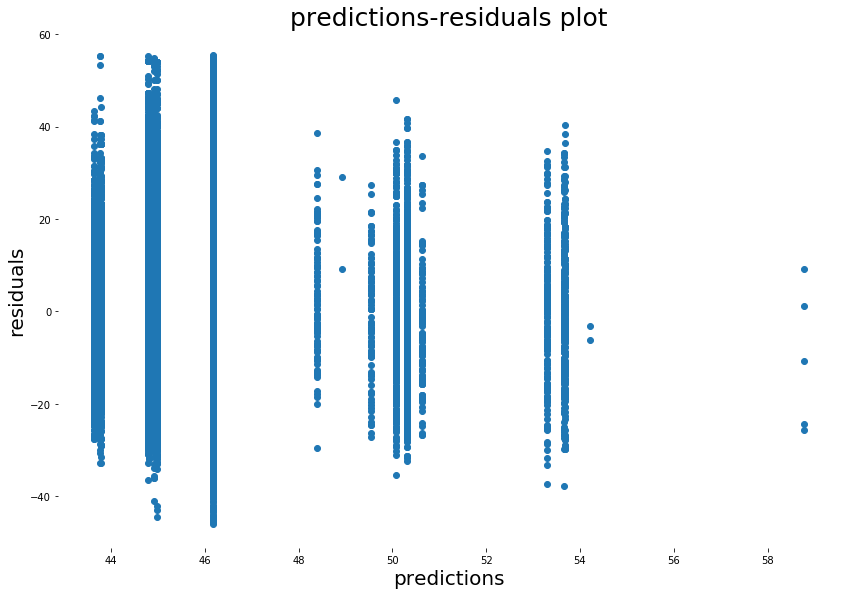

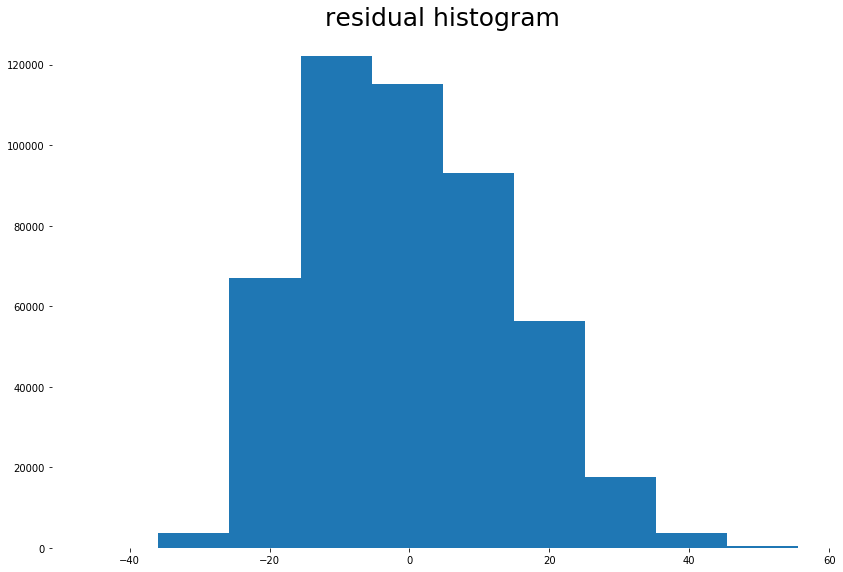

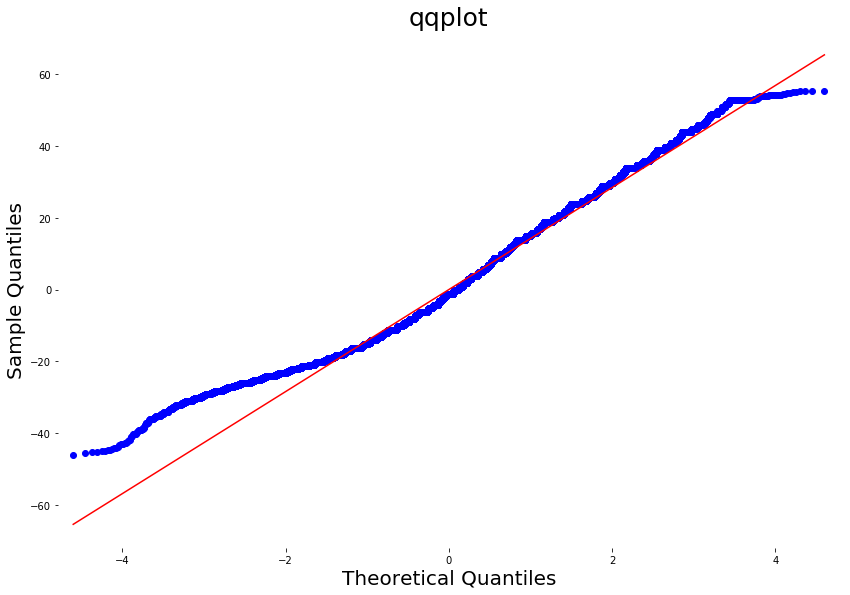

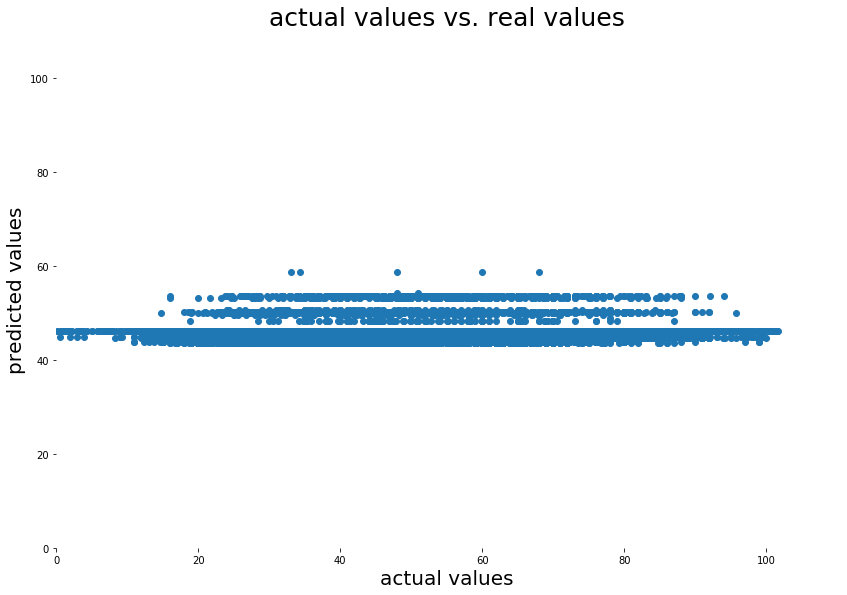

In [8]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion and cooking_fuel
The Mean of the residuals is: 2.327193360889134e-05
The Mean Absolute Error is: 11.673854632452297
The pearson's r coefficient between the predictions and actual values is: 0.09816127904394506 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


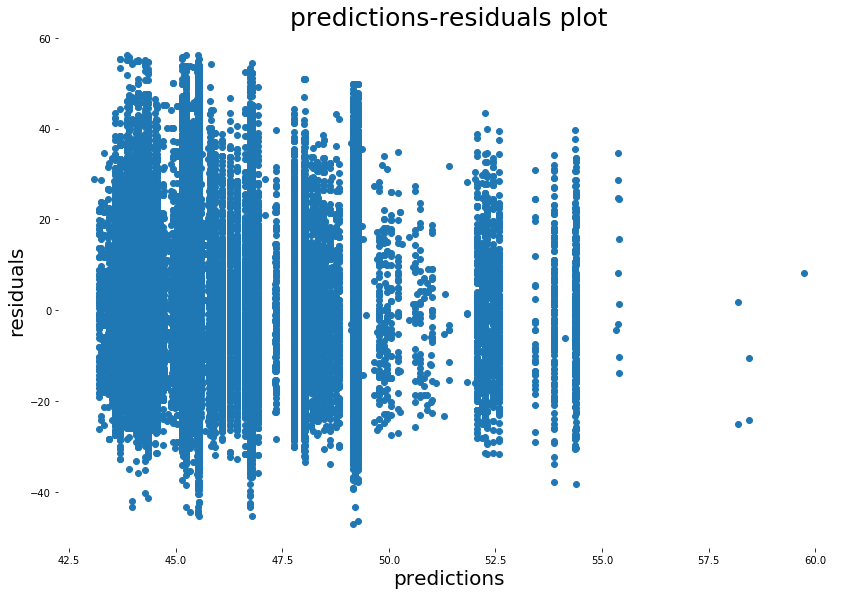

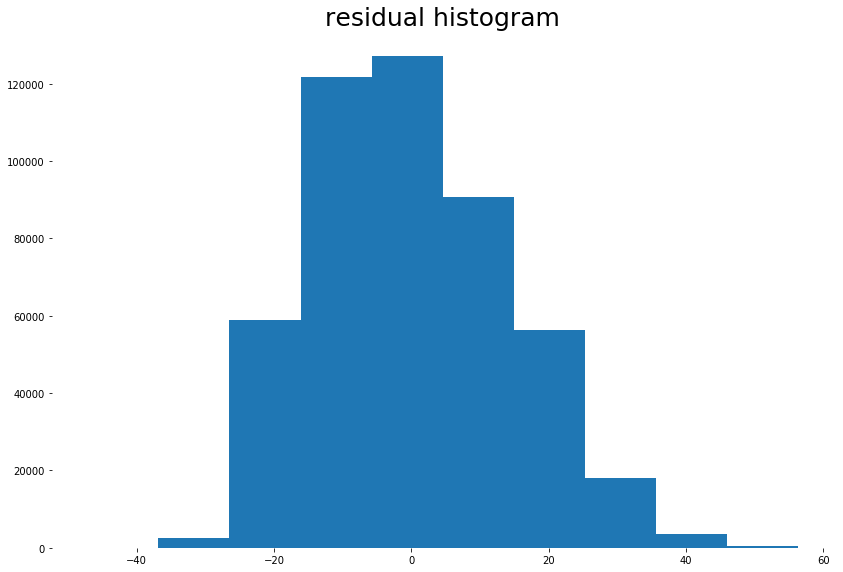

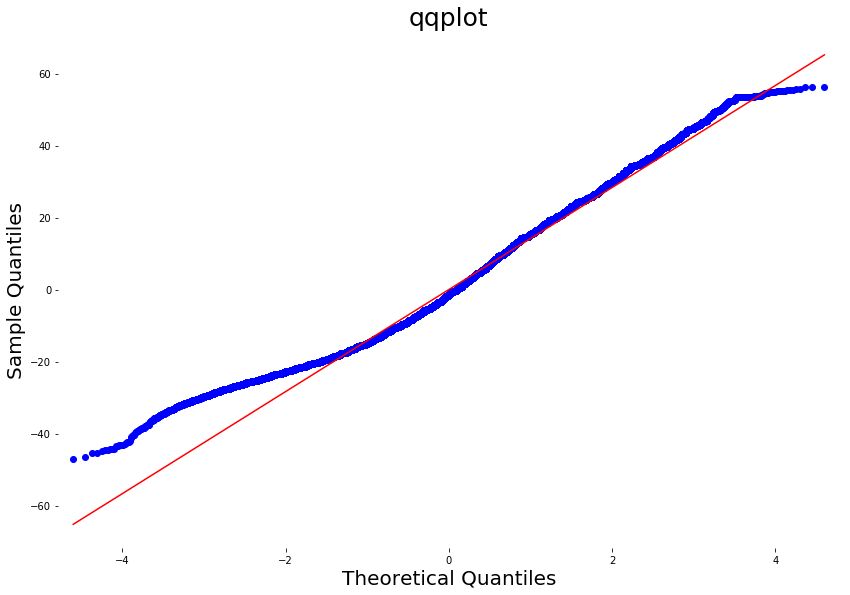

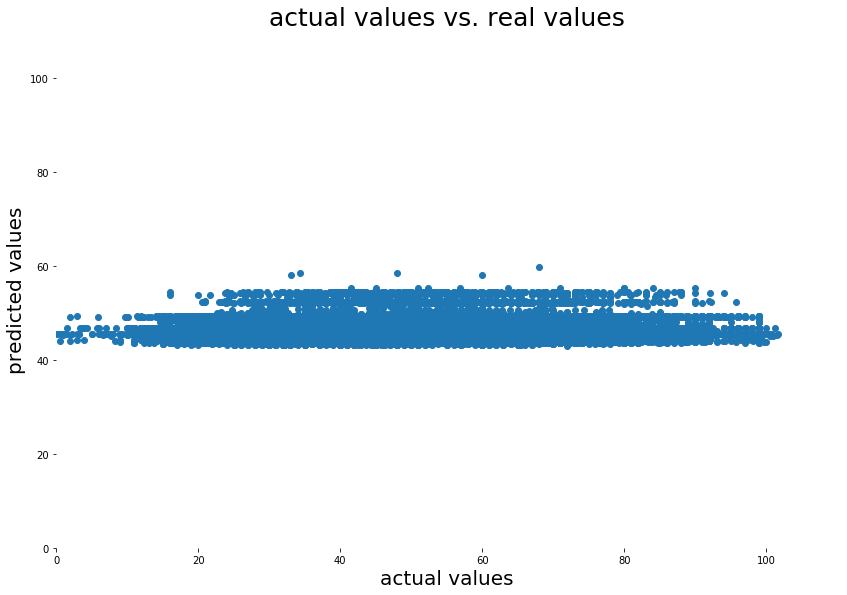

In [9]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel and kitchen_availability
The Mean of the residuals is: 5.209339132019241e-05
The Mean Absolute Error is: 11.647488066016424
The pearson's r coefficient between the predictions and actual values is: 0.11390988743661938 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


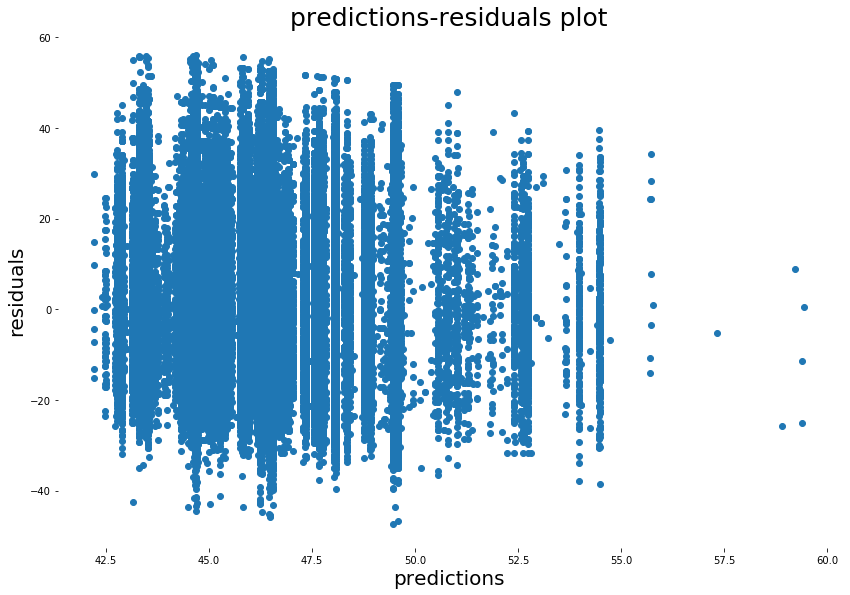

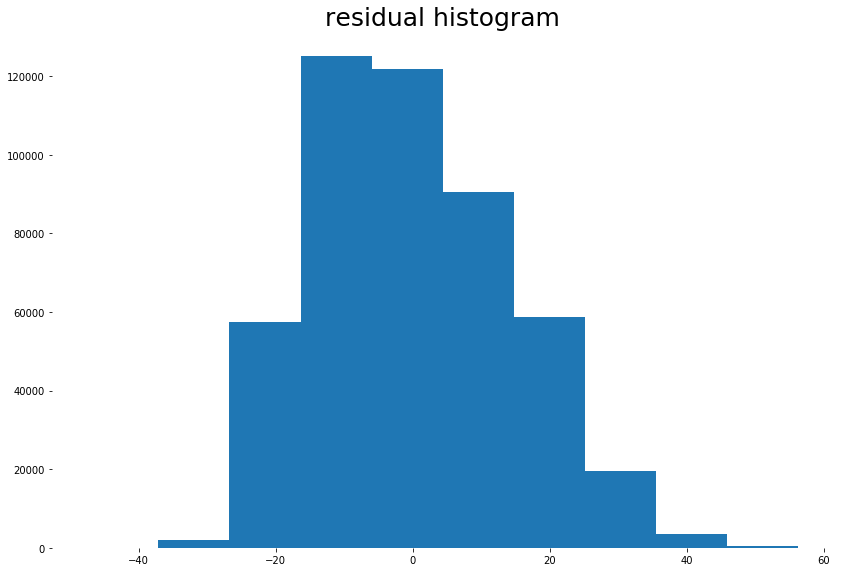

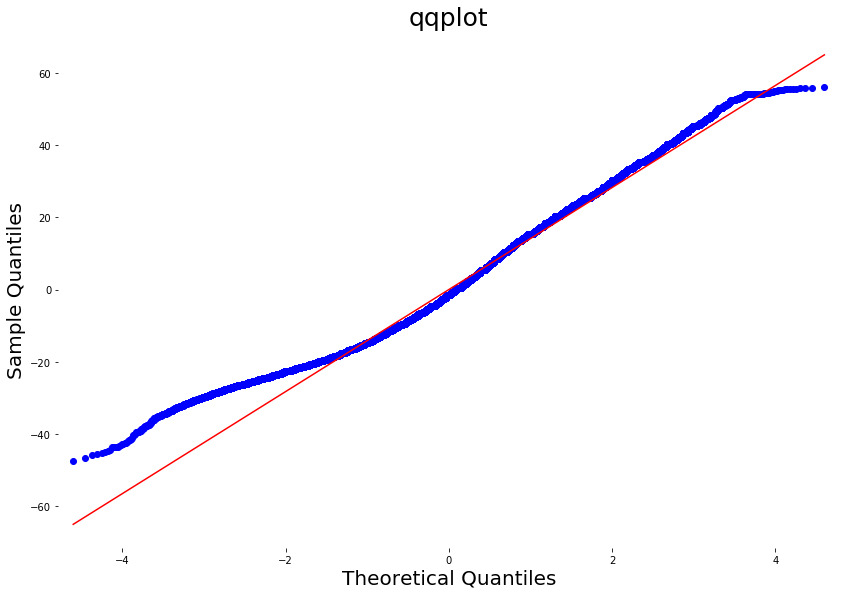

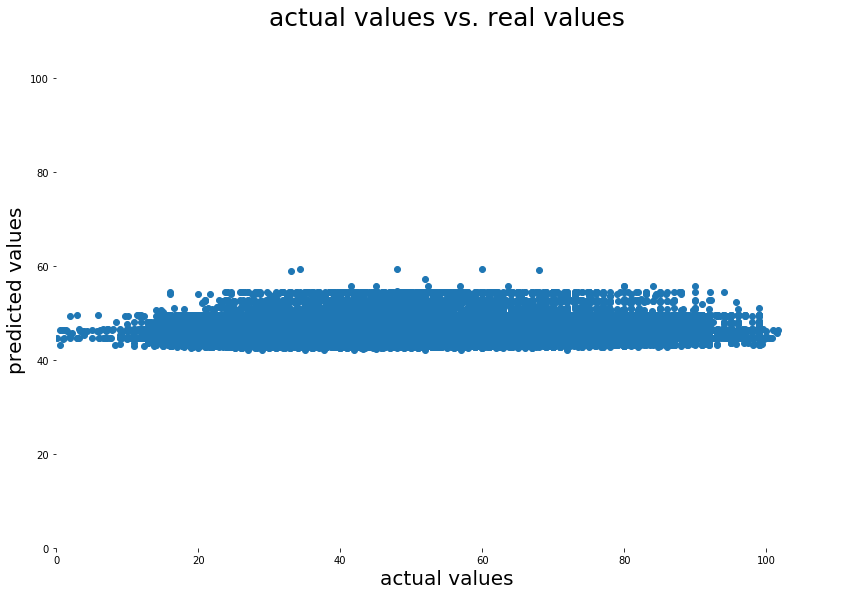

In [10]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability and is_telephone
The Mean of the residuals is: 7.419607941506429e-05
The Mean Absolute Error is: 11.61451229618043
The pearson's r coefficient between the predictions and actual values is: 0.1283846270535273 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


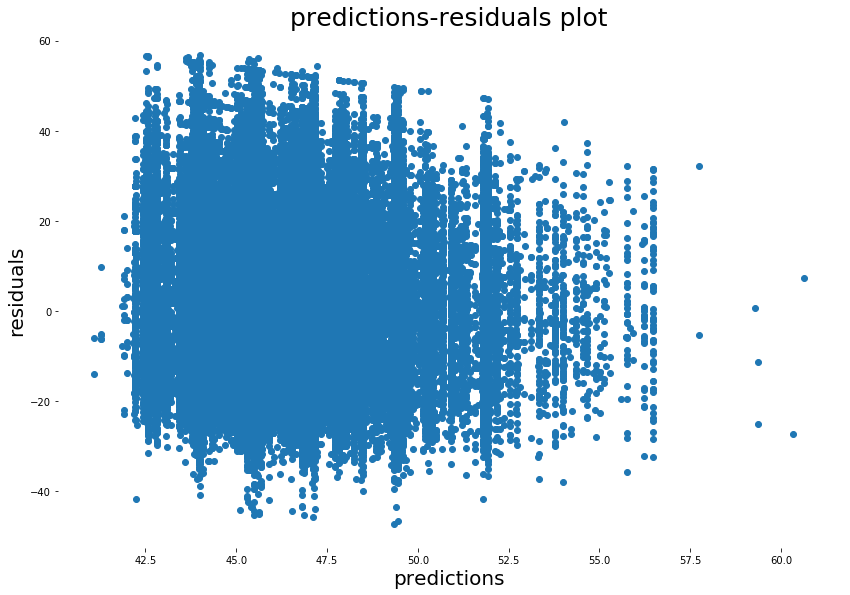

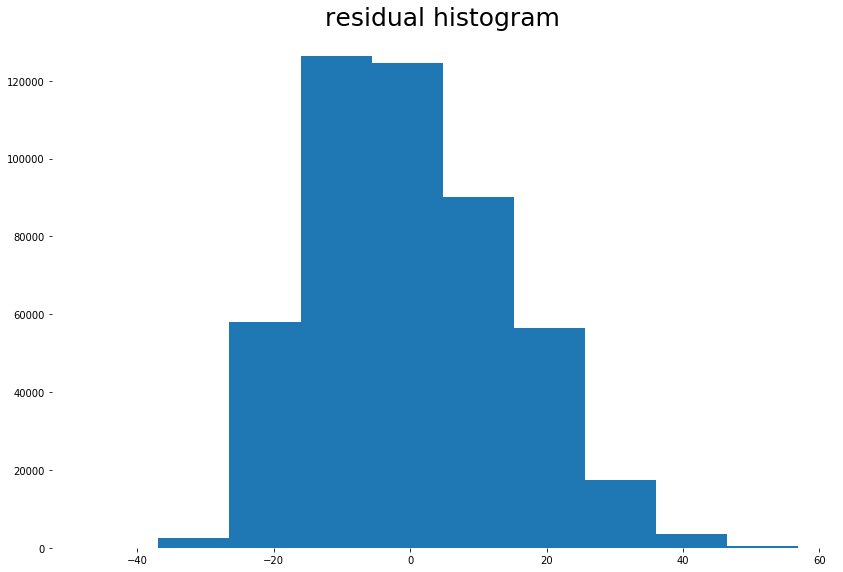

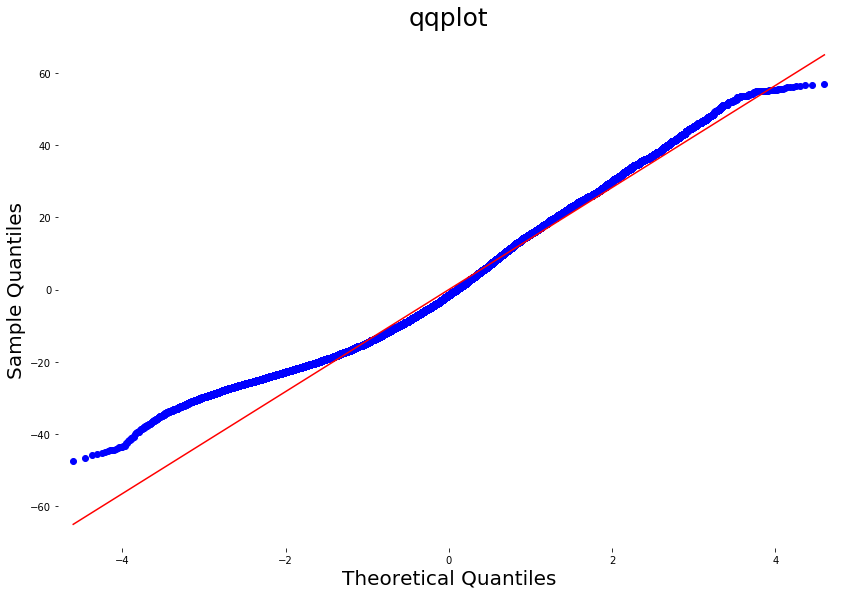

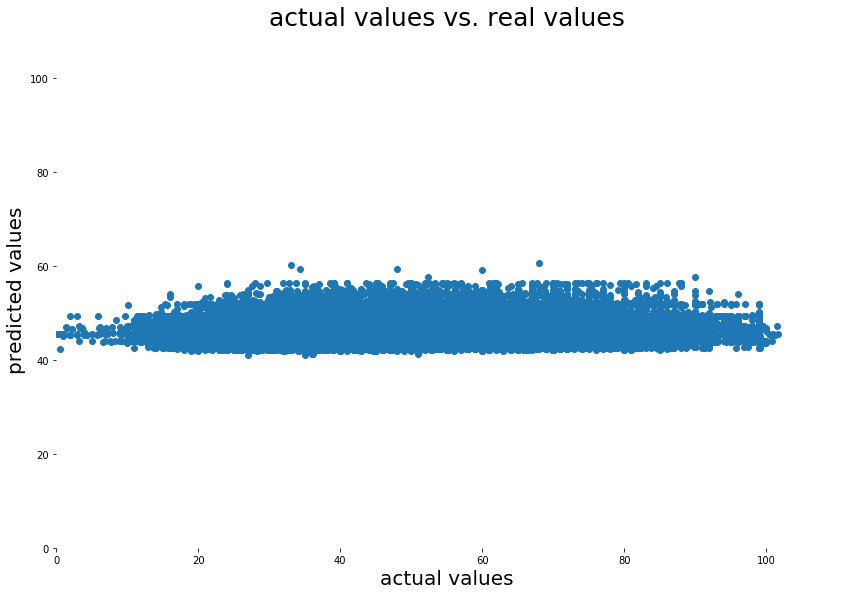

In [11]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone and is_car
The Mean of the residuals is: 7.835170471593771e-05
The Mean Absolute Error is: 11.608280660703256
The pearson's r coefficient between the predictions and actual values is: 0.13183085146450638 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


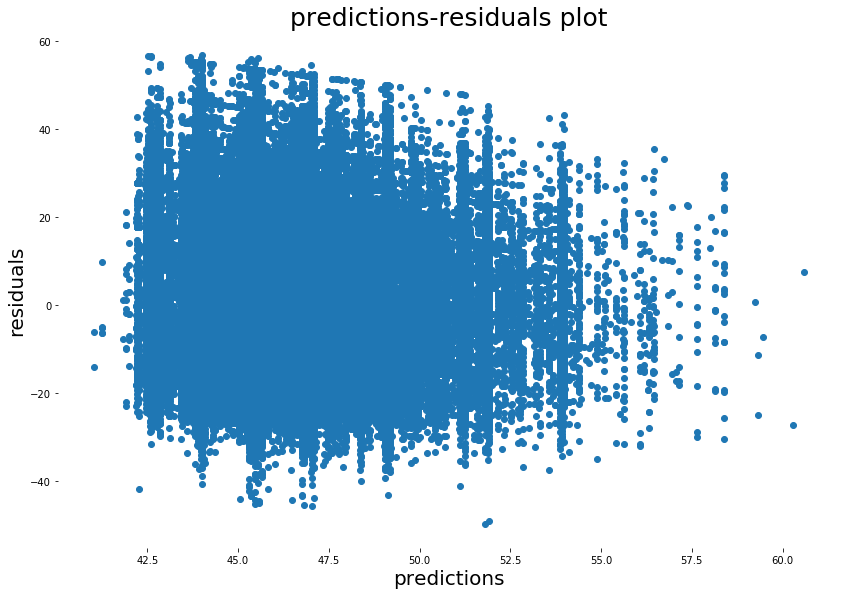

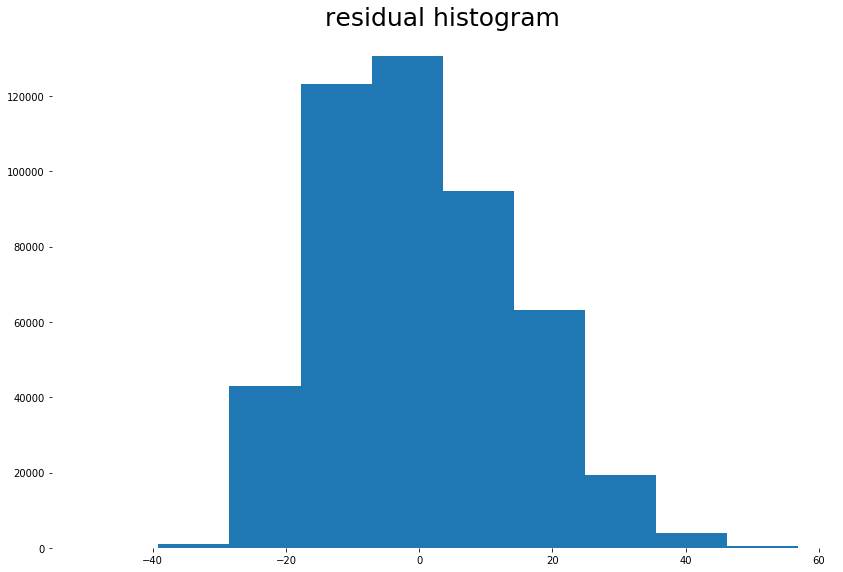

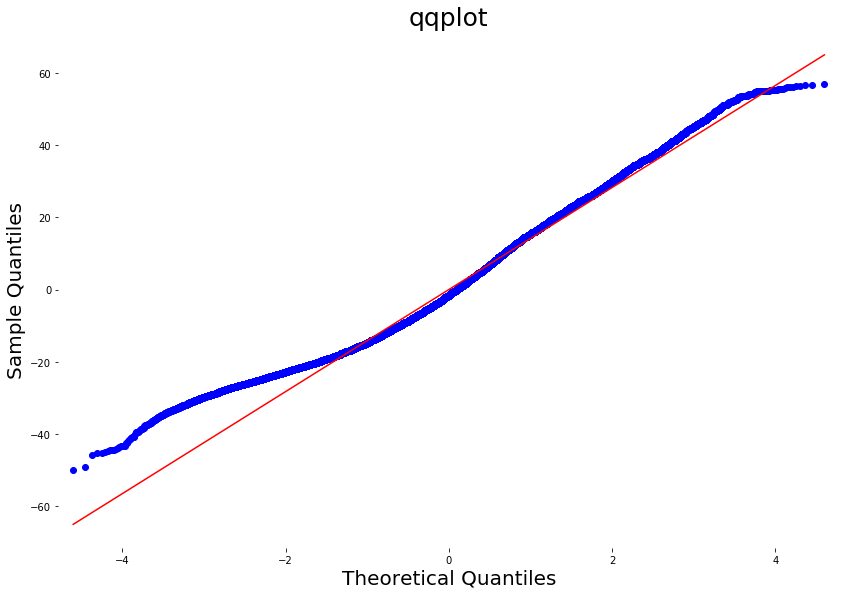

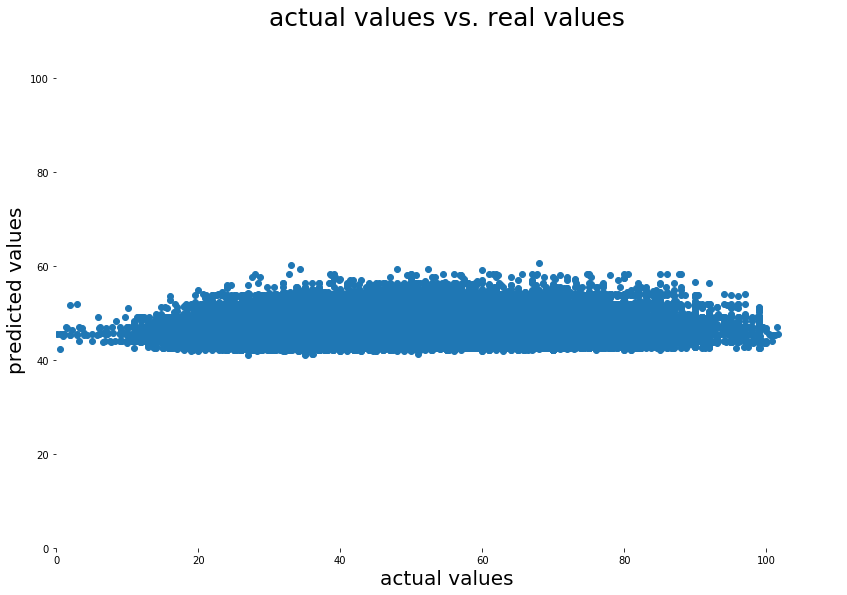

In [12]:
mae_prediction_residual_plot(X_train[make_col_list()])

In [13]:
current_col_list.append('no_of_dwelling_rooms')

In [14]:
current_col_list

['religion',
 'cooking_fuel',
 'kitchen_availability',
 'is_telephone',
 'is_car',
 'no_of_dwelling_rooms']

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car and no_of_dwelling_rooms
The Mean of the residuals is: 9.404964791997653e-05
The Mean Absolute Error is: 11.434710408844683
The pearson's r coefficient between the predictions and actual values is: 0.19882363340868428 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


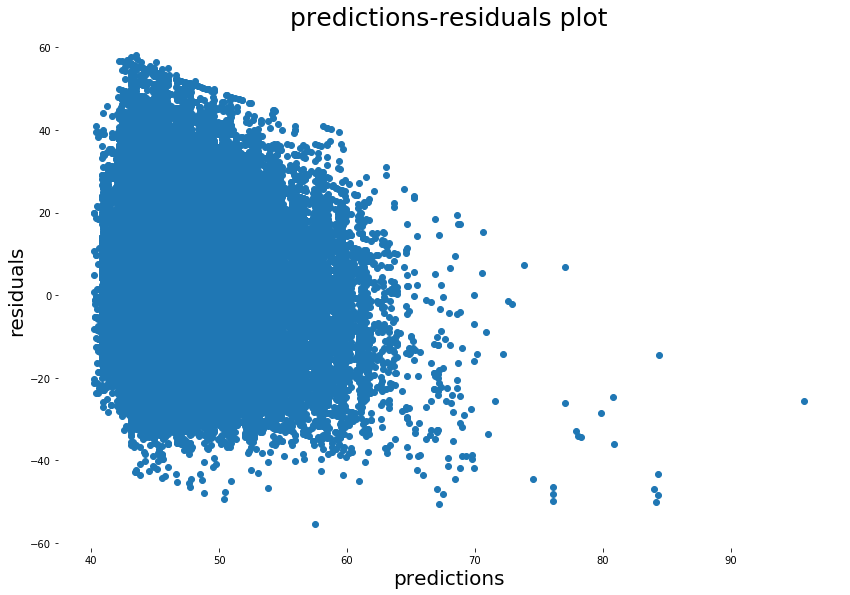

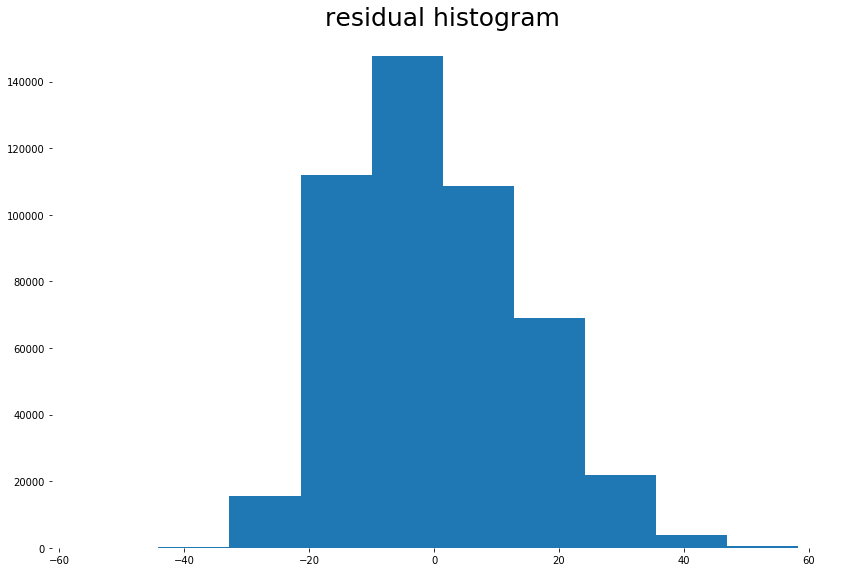

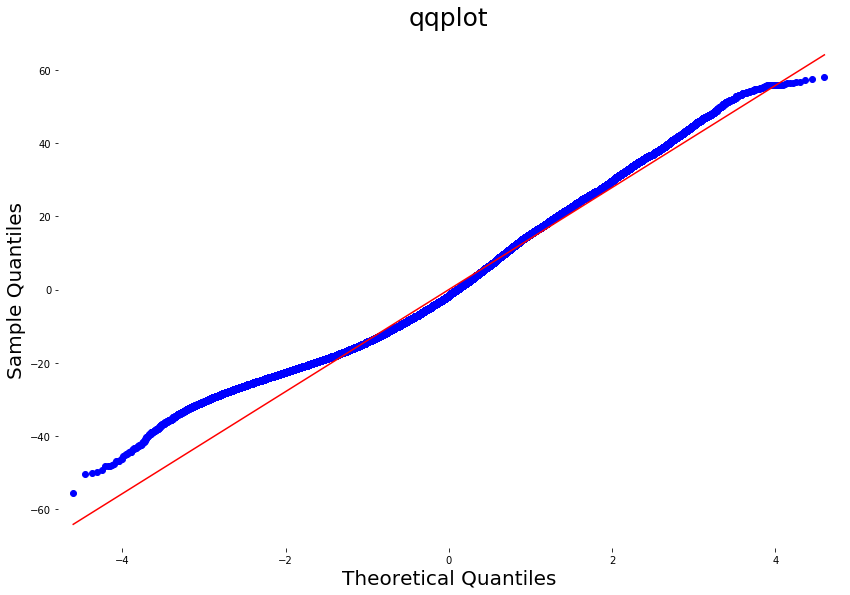

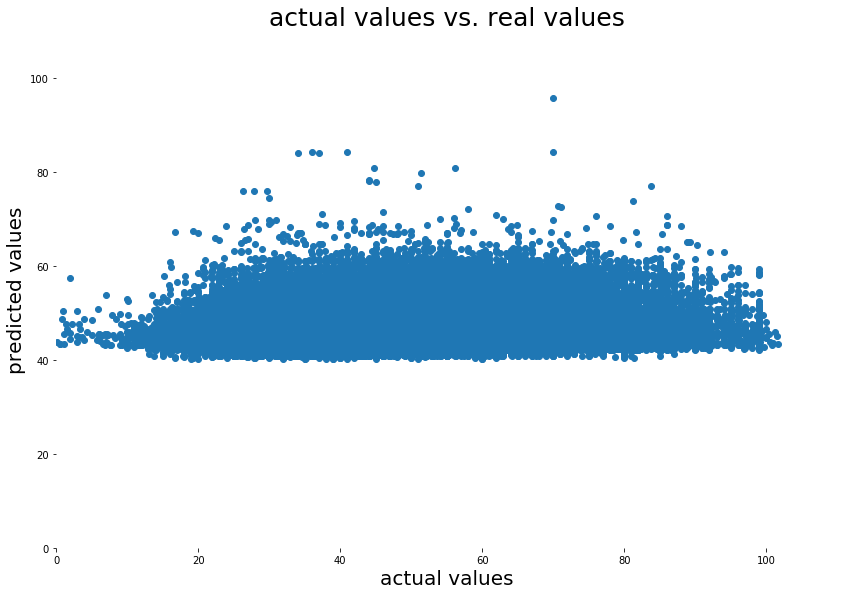

In [15]:
mae_prediction_residual_plot(X_train[current_col_list])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms and is_tractor
The Mean of the residuals is: 9.527437039201825e-05
The Mean Absolute Error is: 11.432327611134799
The pearson's r coefficient between the predictions and actual values is: 0.1997115322907807 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


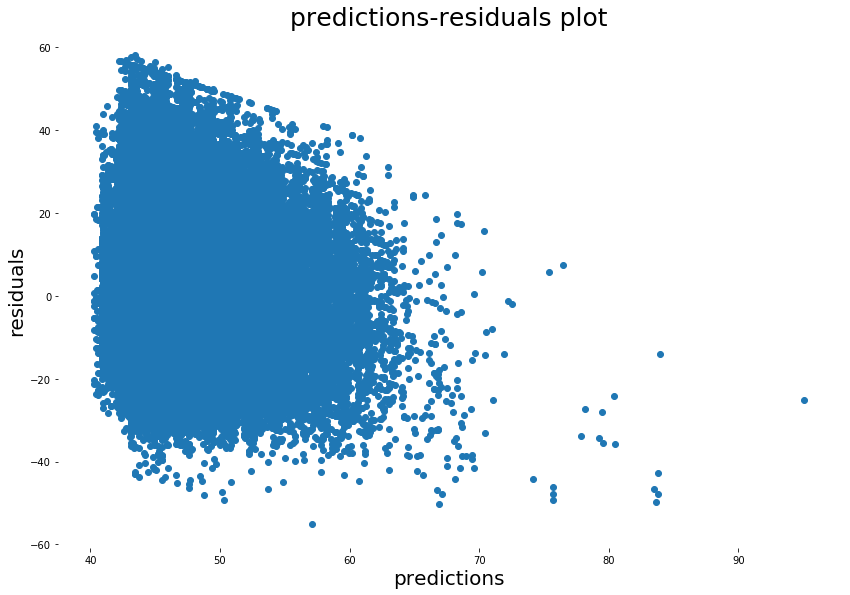

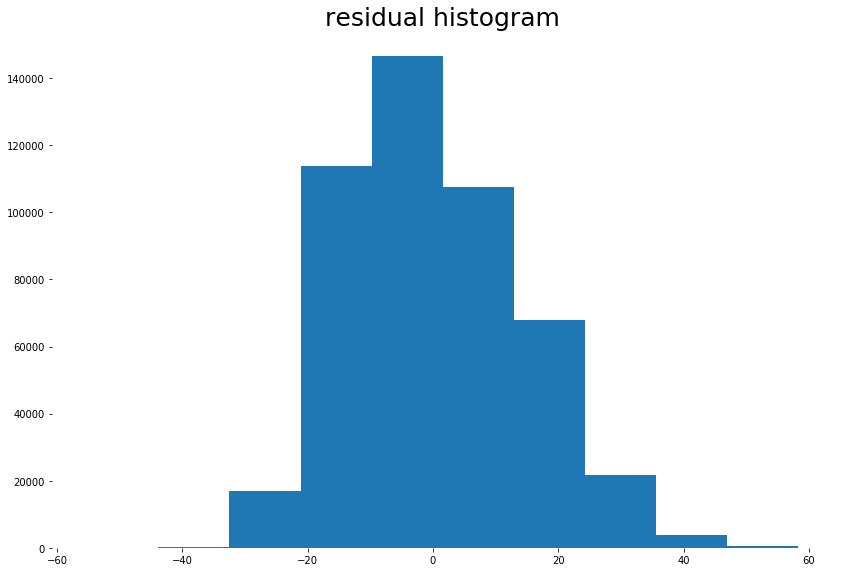

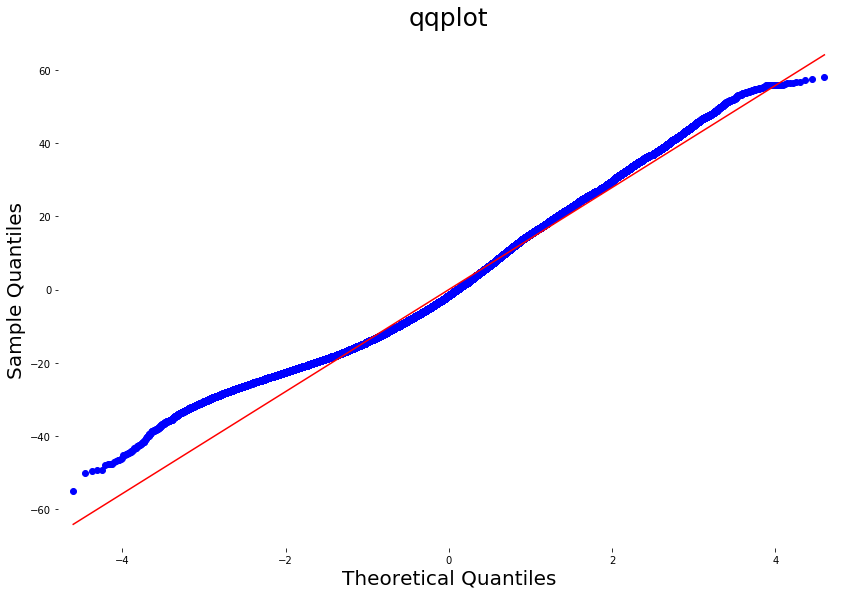

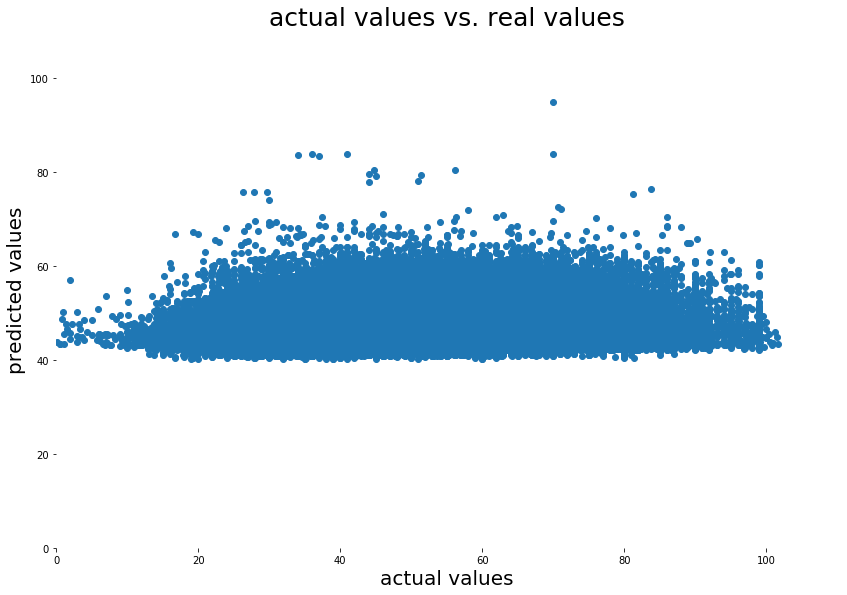

In [16]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor and land_possessed
The Mean of the residuals is: 0.00012361354382806205
The Mean Absolute Error is: 11.405221346657118
The pearson's r coefficient between the predictions and actual values is: 0.20843175128555508 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


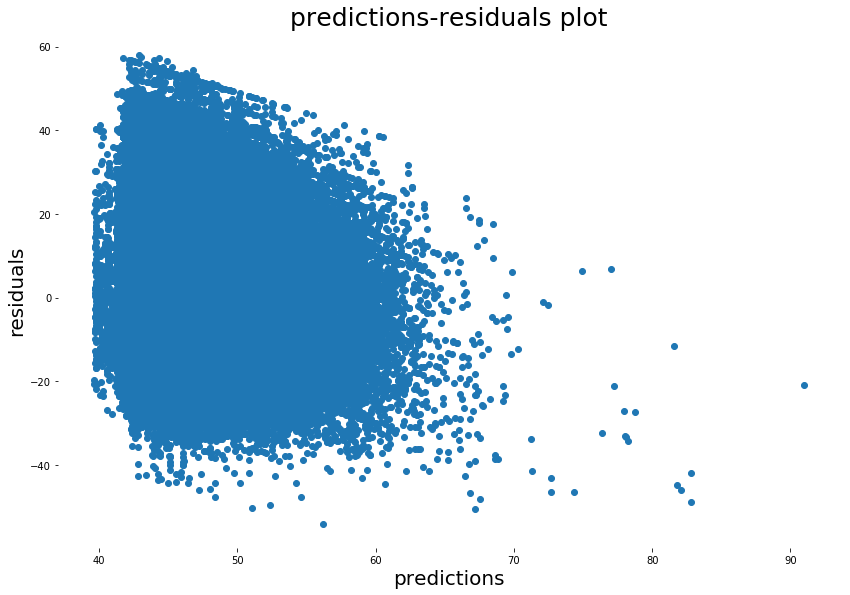

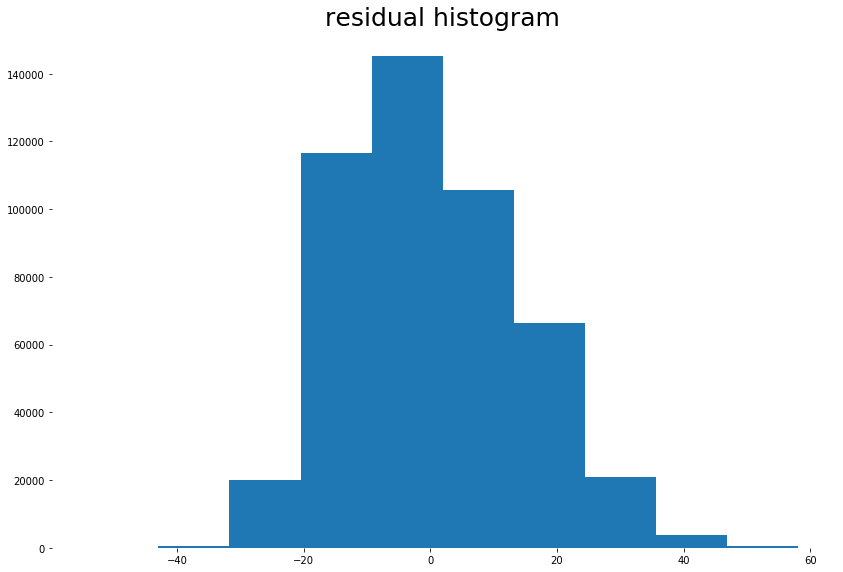

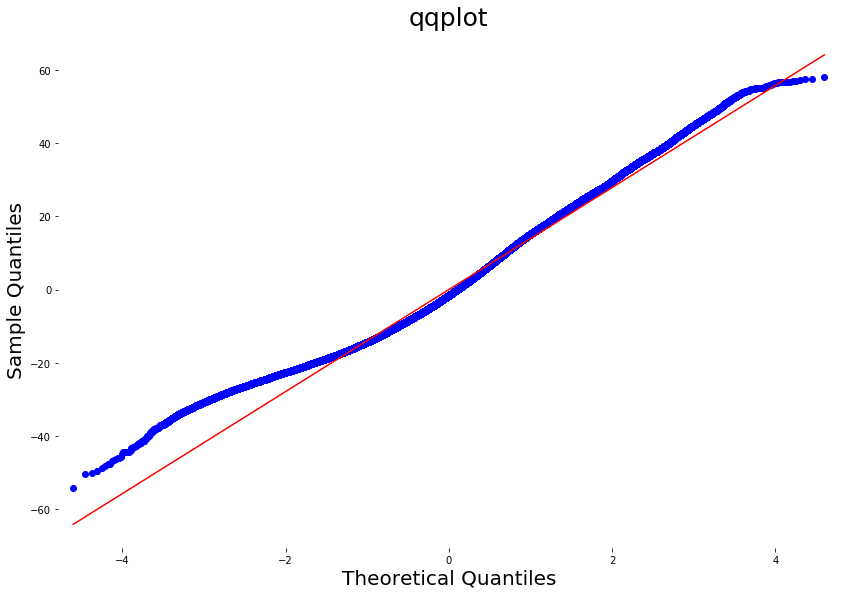

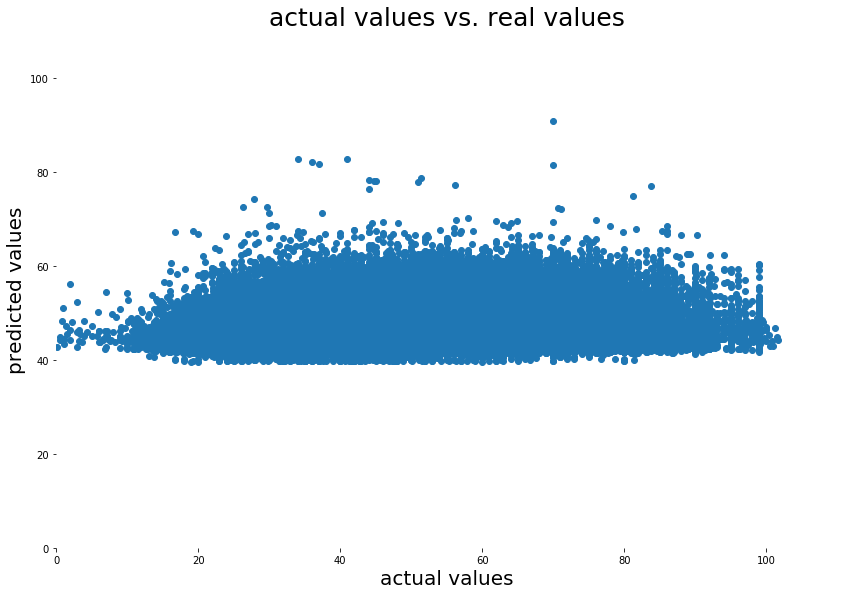

In [17]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed and state
The Mean of the residuals is: 0.0002619237499454721
The Mean Absolute Error is: 11.37320791849929
The pearson's r coefficient between the predictions and actual values is: 0.2194046464803867 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


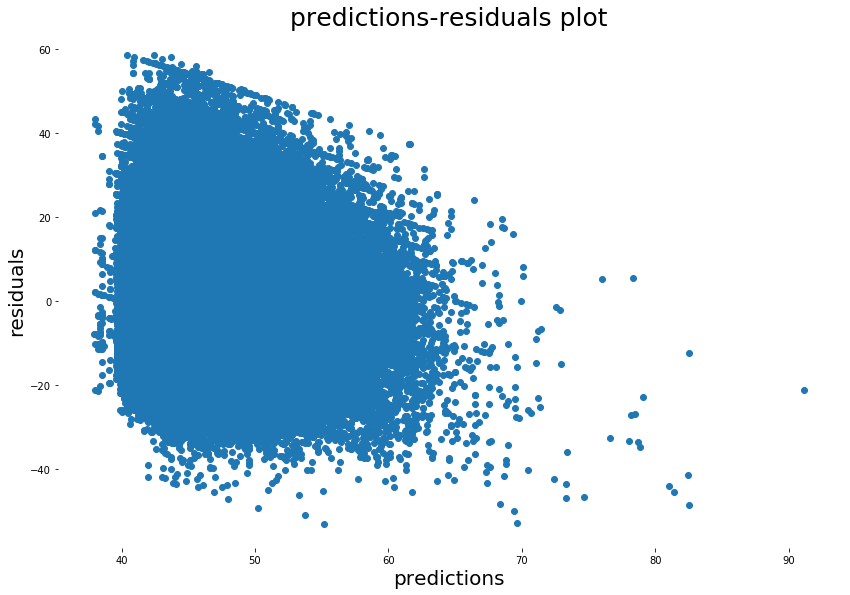

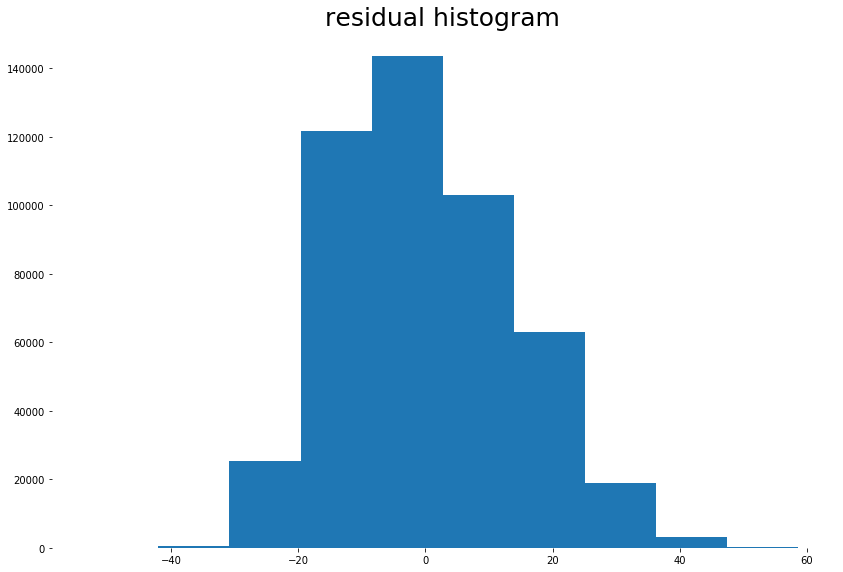

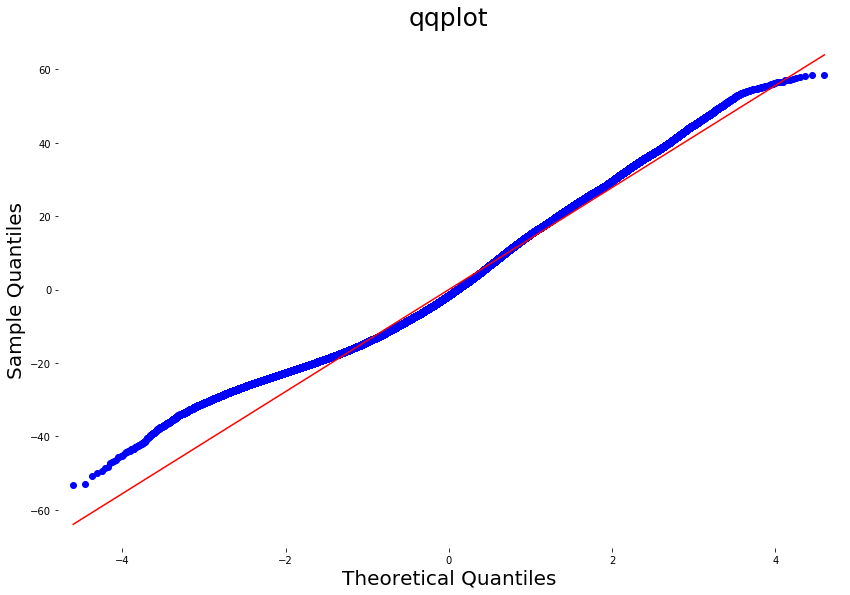

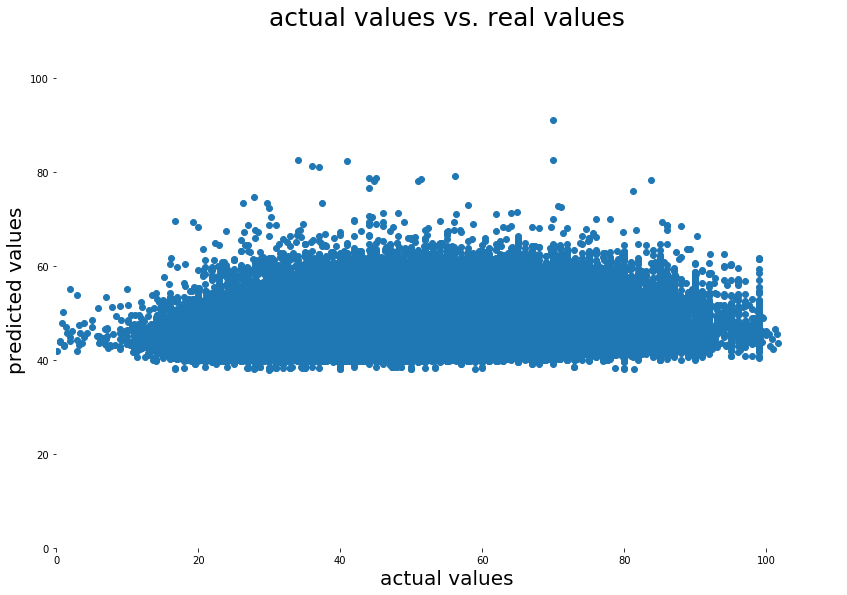

In [18]:
mae_prediction_residual_plot(X_train[make_col_list()])

## No Outliers

**I'll now leave out outliers in the 'lifetime' column I aim to predict and see how the results change.**

In [19]:
no_outliers_y_train = y_train[(y_train < np.mean(y_train) + 2*np.std(y_train)) & (y_train > np.mean(y_train)) - 2*np.std(y_train)]

In [20]:
no_outliers_X_train = X_train[(y_train < np.mean(y_train) + 2*np.std(y_train)) & (y_train > np.mean(y_train)) - 2*np.std(y_train)]

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed and state
The Mean of the residuals is: 0.00019772018764532067
The Mean Absolute Error is: 10.61605363946316
The pearson's r coefficient between the predictions and actual values is: 0.2150881980444248 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


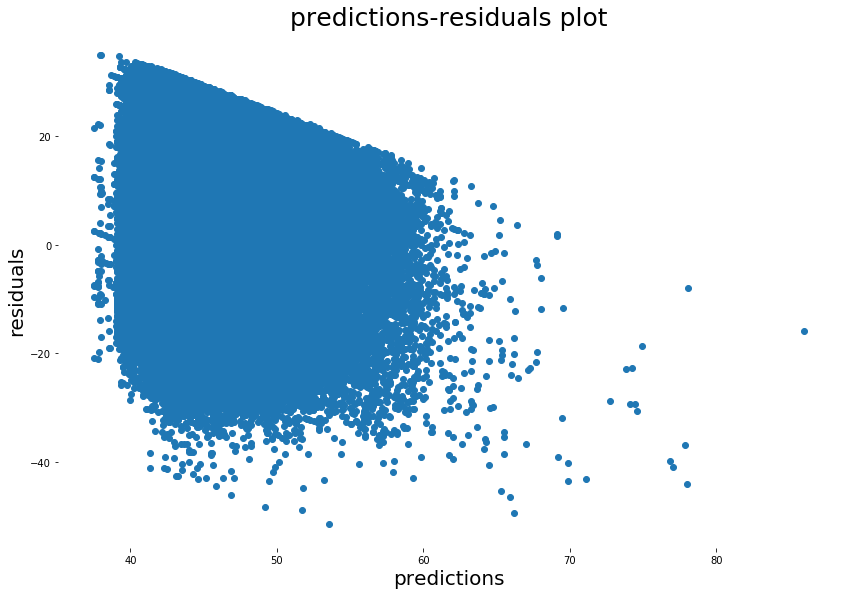

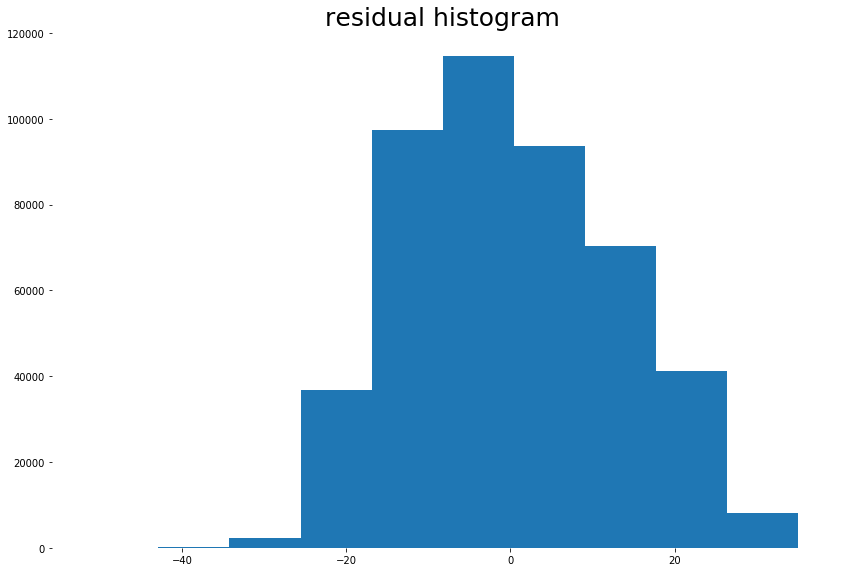

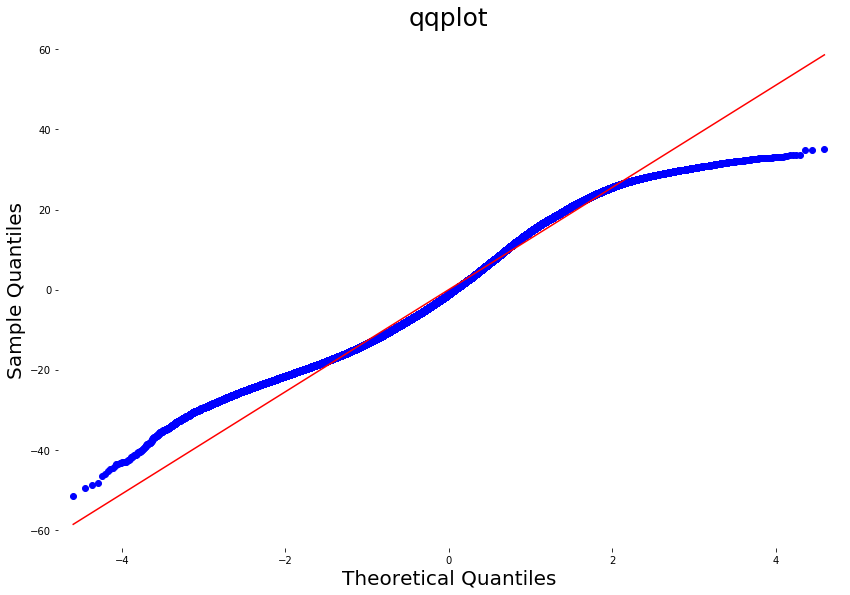

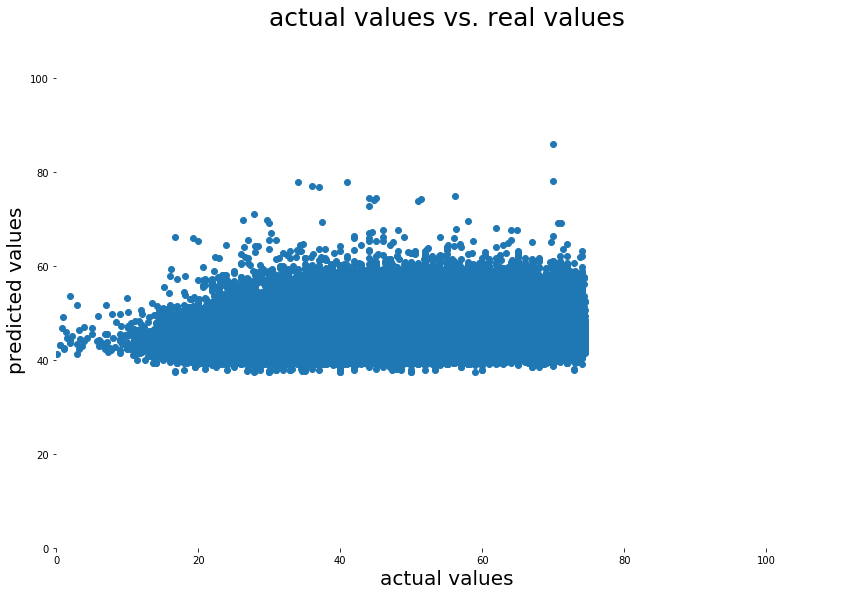

In [21]:
mae_prediction_residual_plot(no_outliers_X_train[current_col_list], no_outliers_y_train)

**Leaving out the outliers in the lifetime column did lead to a slight improvement of the mean absolute error. But at the same time the pearson's r coefficient is lower than in the model using the outliers as well. This and the histogram of the residuals suggest that the improvement of the mean absolute error, is only due to reduced likeliness of very high positive outliers as the actual lifetime is capped. For this reason I will readd the 'lifetime' outliers to the model.**

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state and toilet_used
The Mean of the residuals is: 0.0003722202040034302
The Mean Absolute Error is: 11.354306582553729
The pearson's r coefficient between the predictions and actual values is: 0.2249938587541449 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


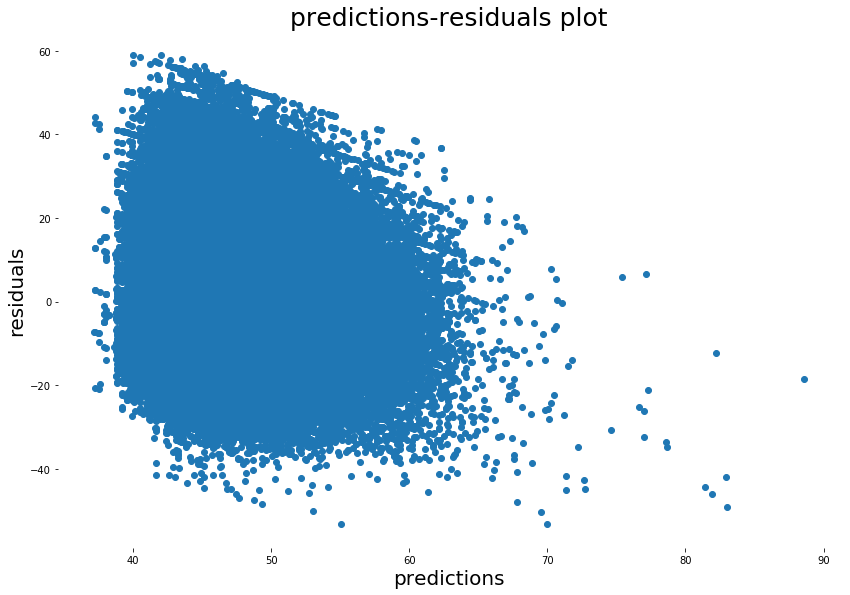

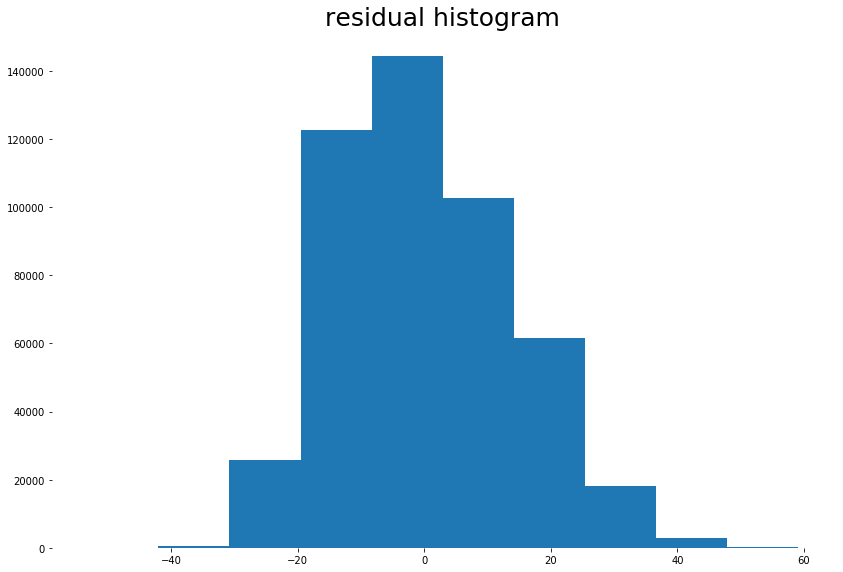

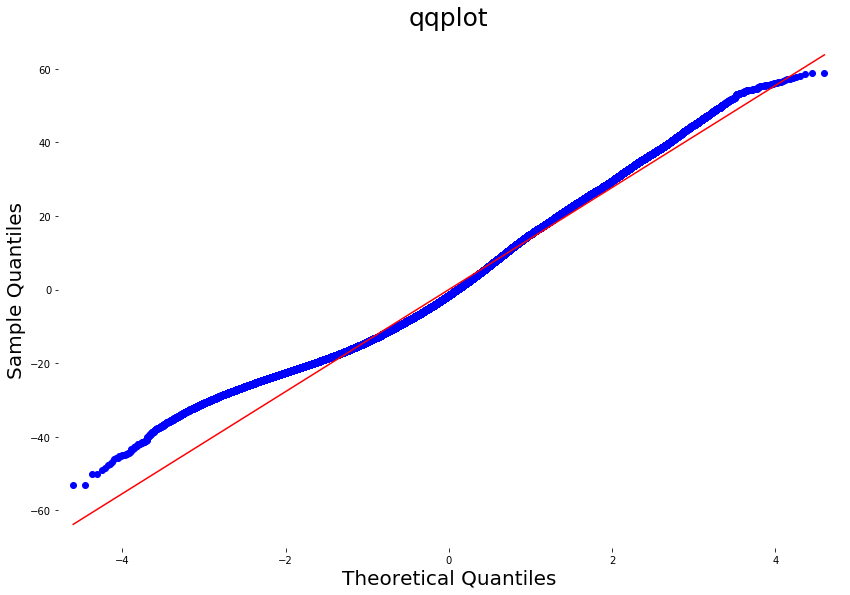

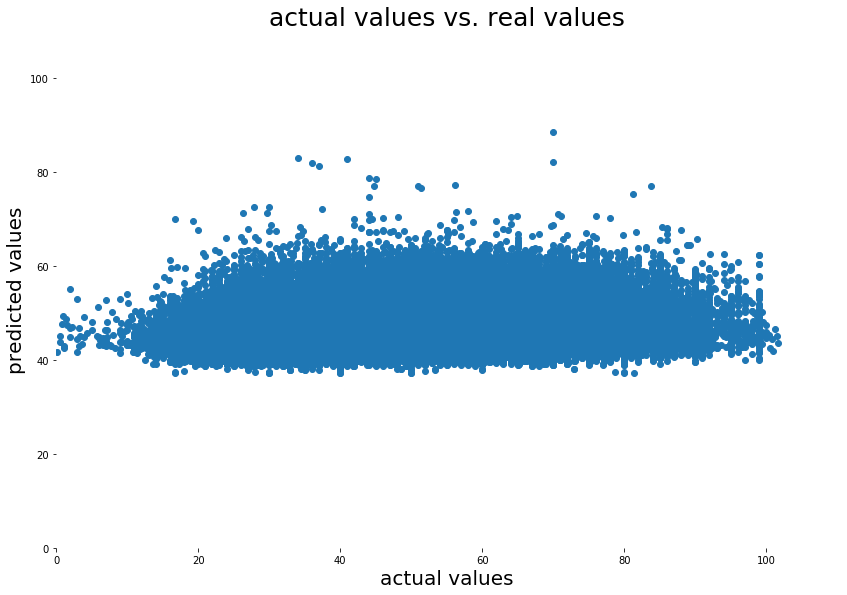

In [22]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used and drinking_water_source
The Mean of the residuals is: 0.00023928024269988889
The Mean Absolute Error is: 11.352504825838412
The pearson's r coefficient between the predictions and actual values is: 0.22566550897525617 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


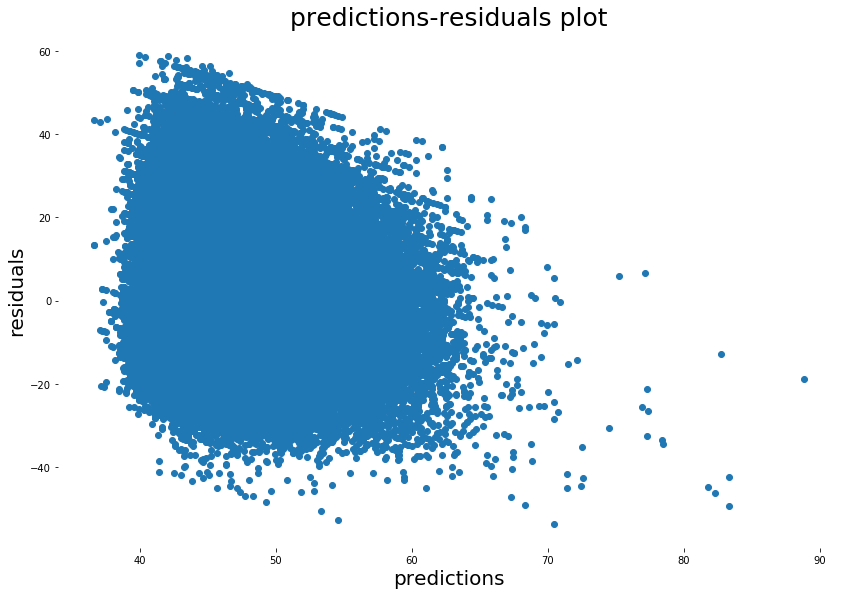

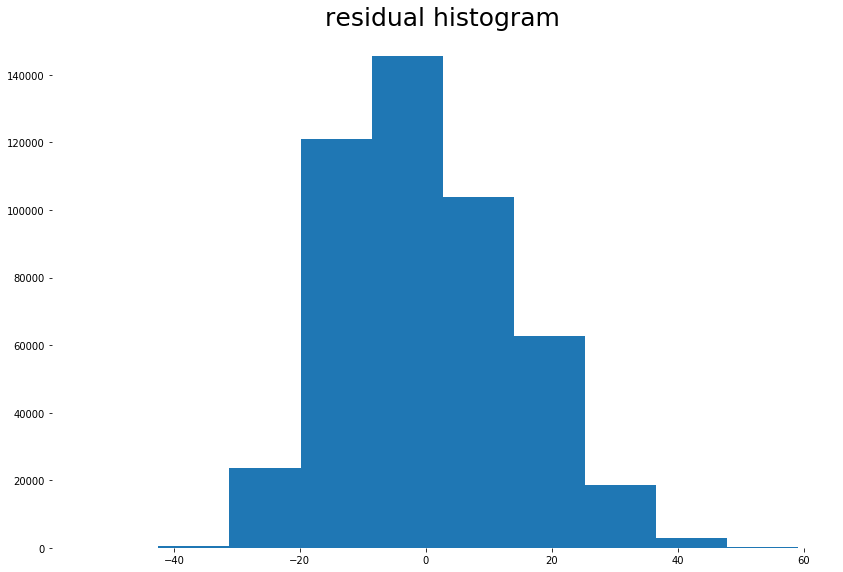

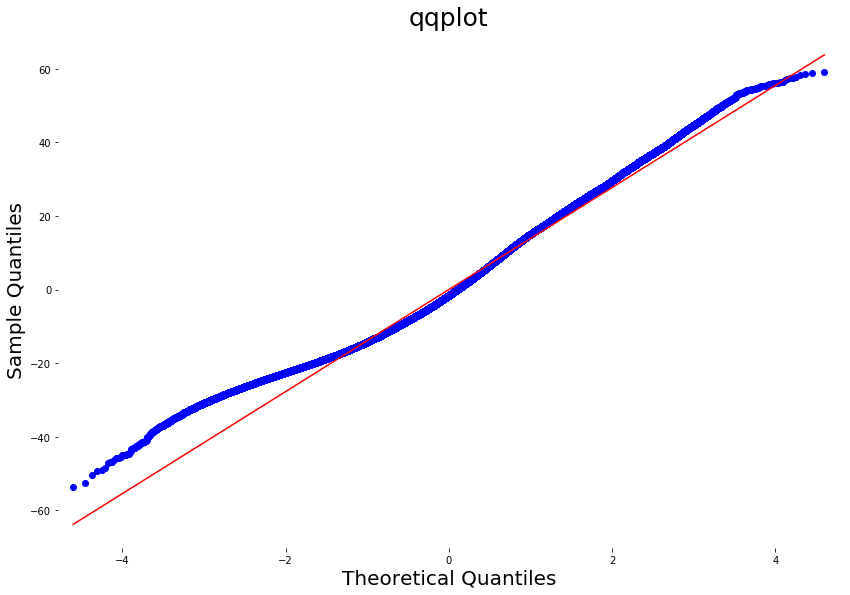

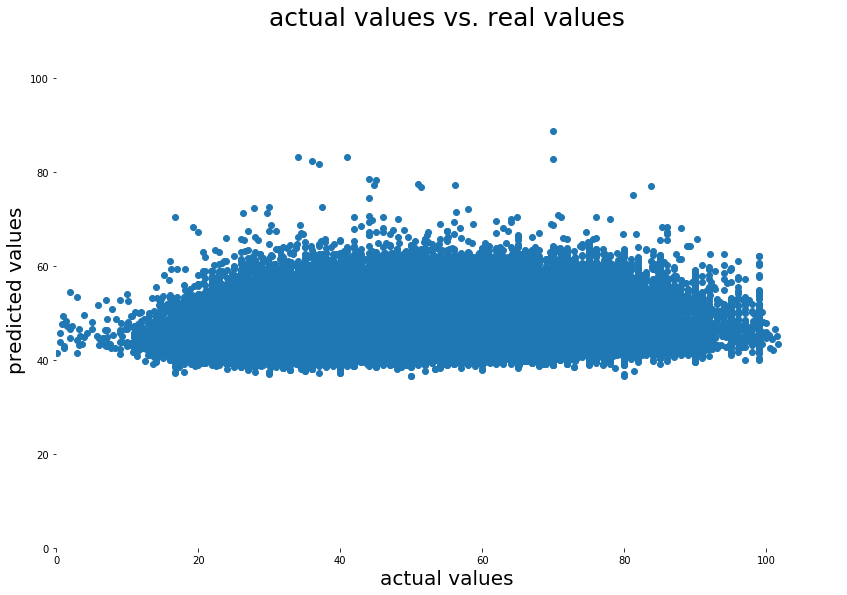

In [23]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source and is_computer
The Mean of the residuals is: 0.00024375203633867078
The Mean Absolute Error is: 11.352556140259273
The pearson's r coefficient between the predictions and actual values is: 0.2256725443611005 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


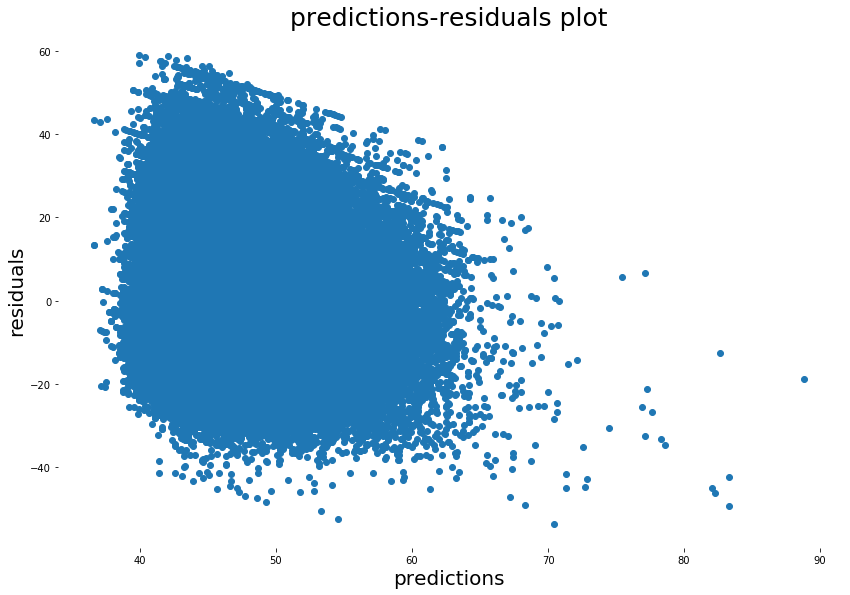

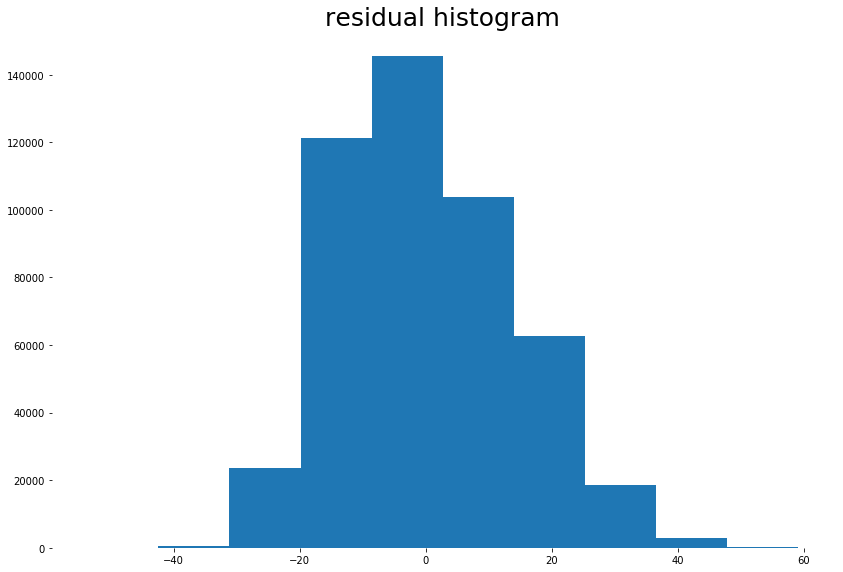

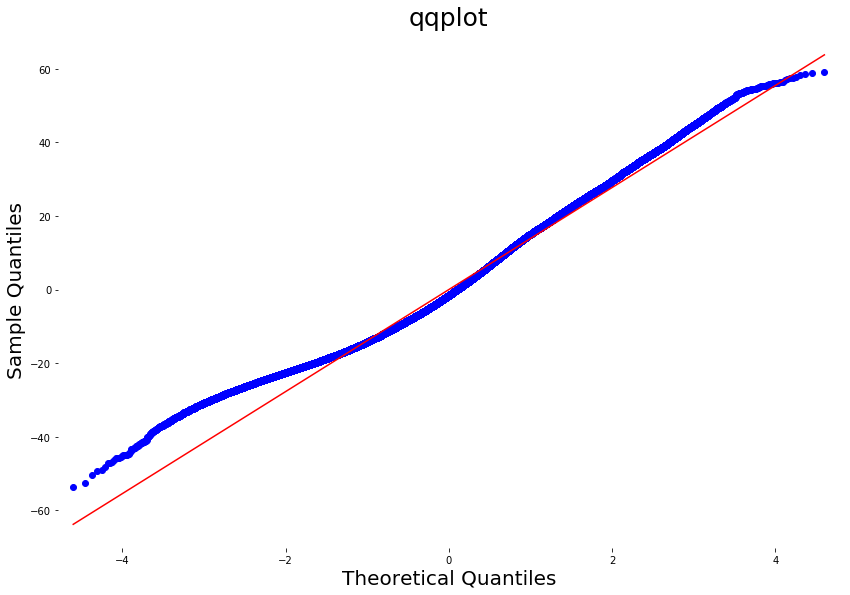

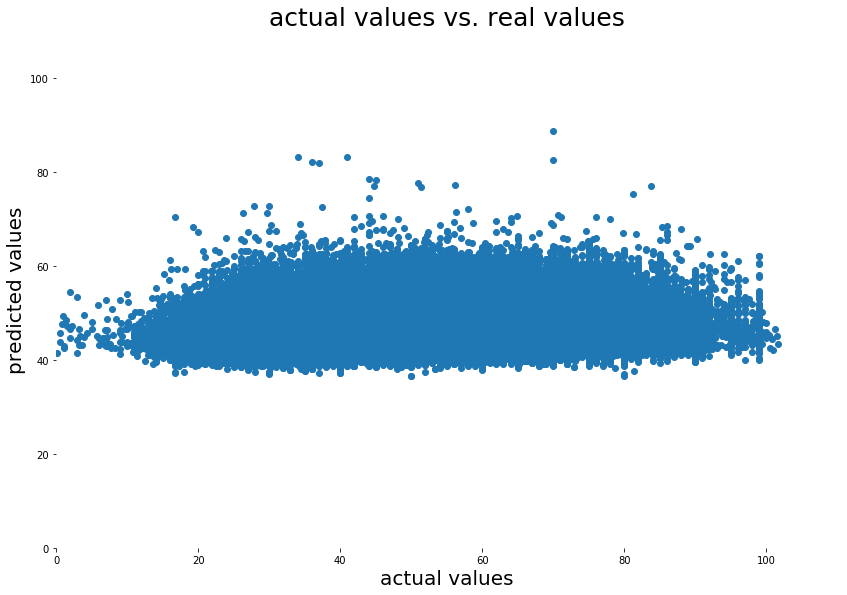

In [24]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer and house_structure
The Mean of the residuals is: 0.00034880767430872075
The Mean Absolute Error is: 11.350214303810272
The pearson's r coefficient between the predictions and actual values is: 0.22648255507394524 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


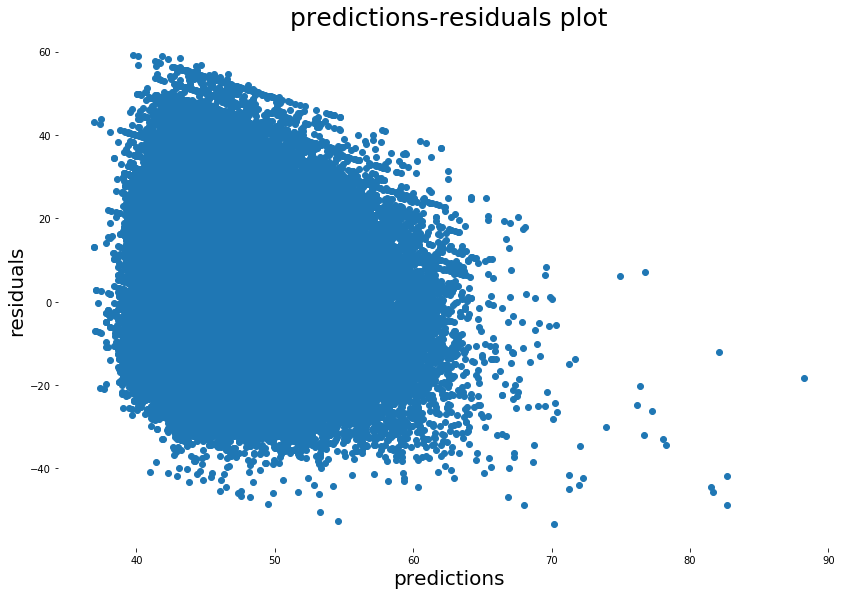

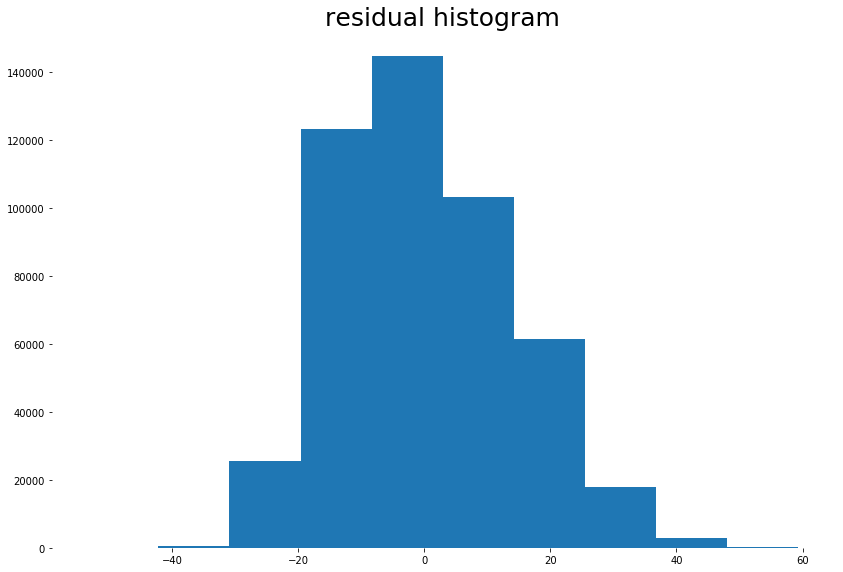

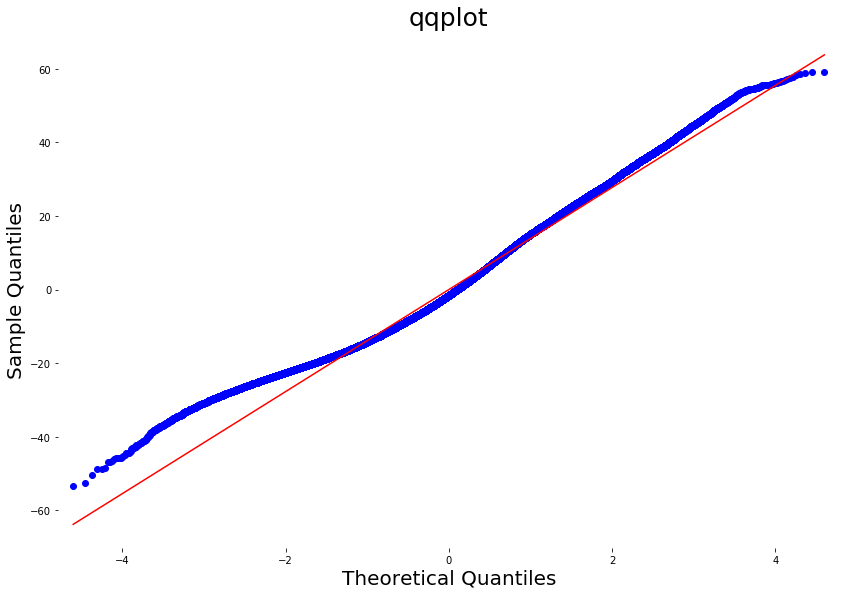

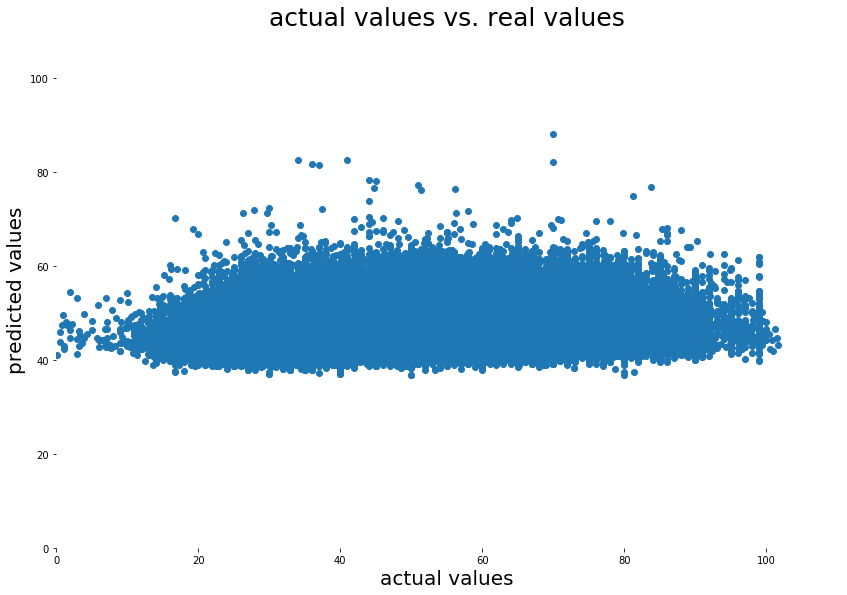

In [25]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure and social_group_code
The Mean of the residuals is: 0.0002615702479591063
The Mean Absolute Error is: 11.335862898544068
The pearson's r coefficient between the predictions and actual values is: 0.23175351570245173 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


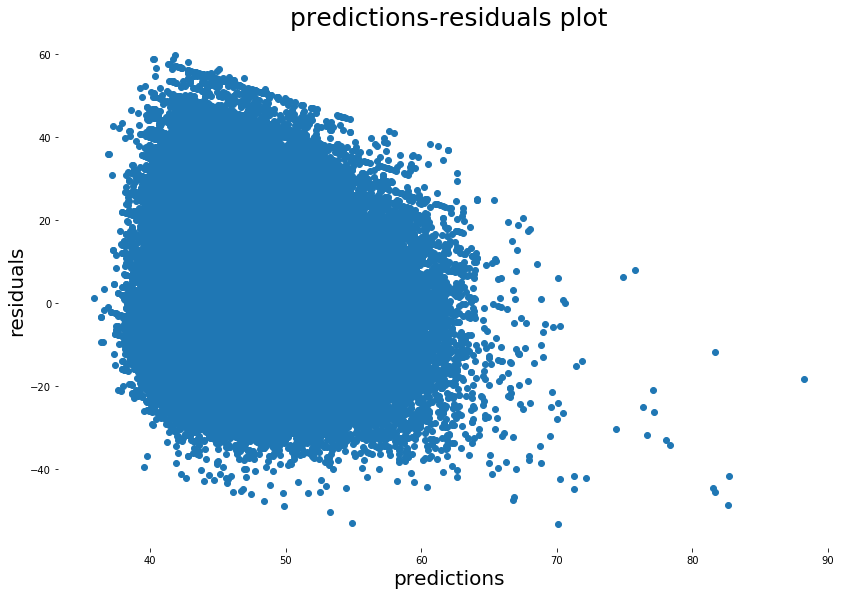

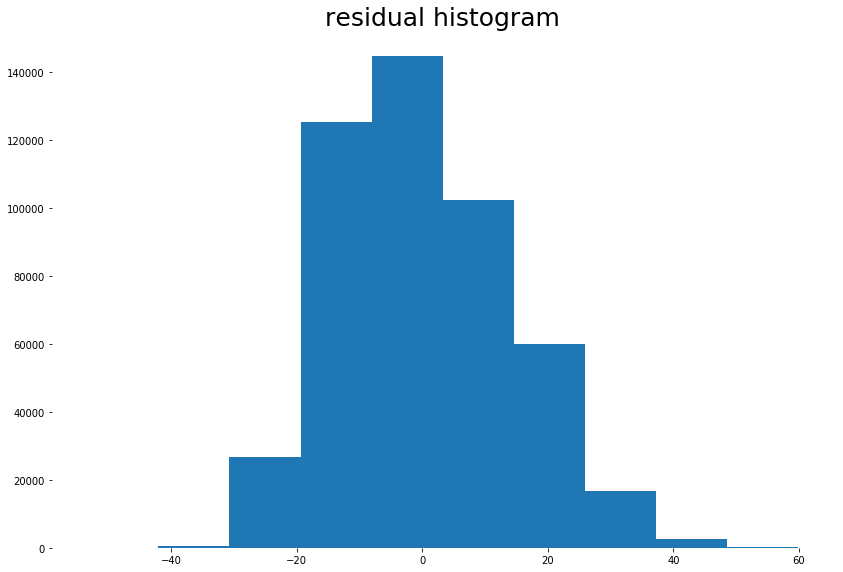

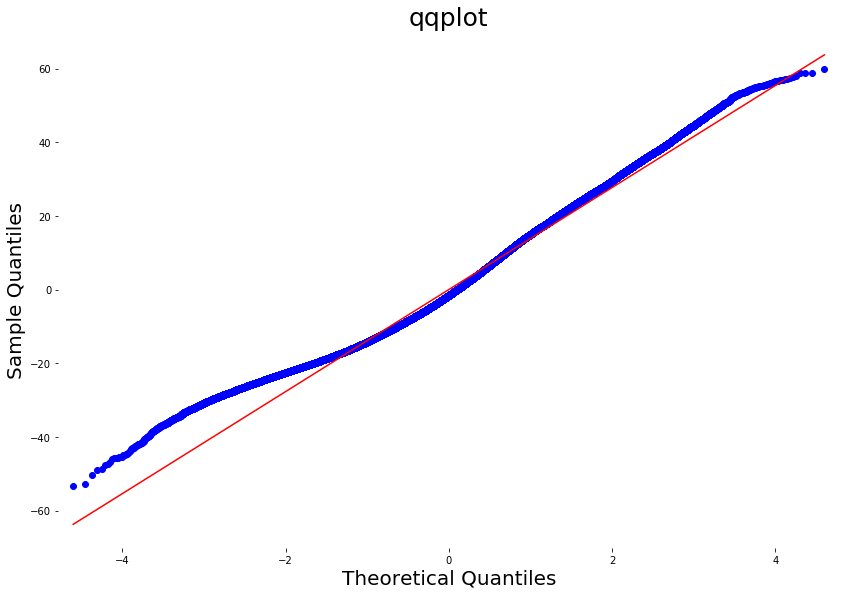

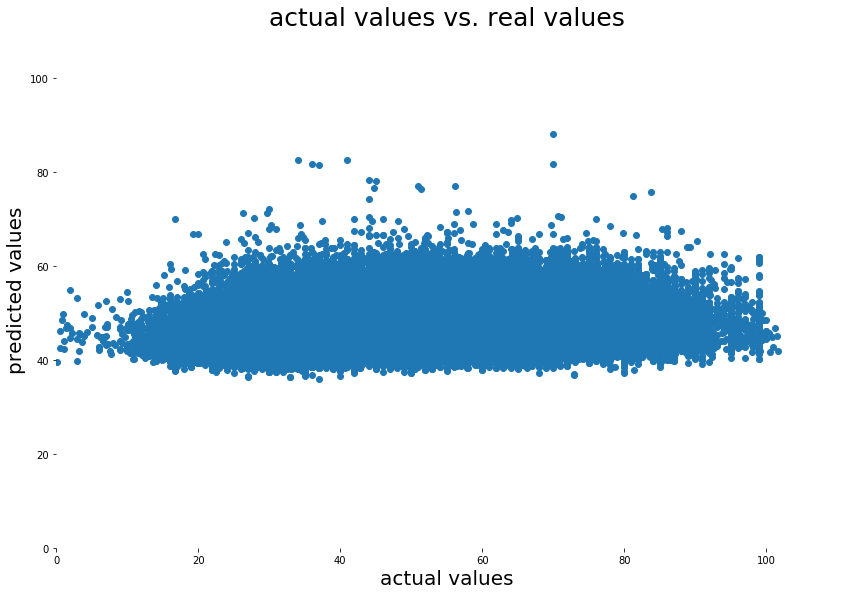

In [26]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code and is_water_pump
The Mean of the residuals is: 0.00018775345303849892
The Mean Absolute Error is: 11.334901443509853
The pearson's r coefficient between the predictions and actual values is: 0.23201579069819925 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


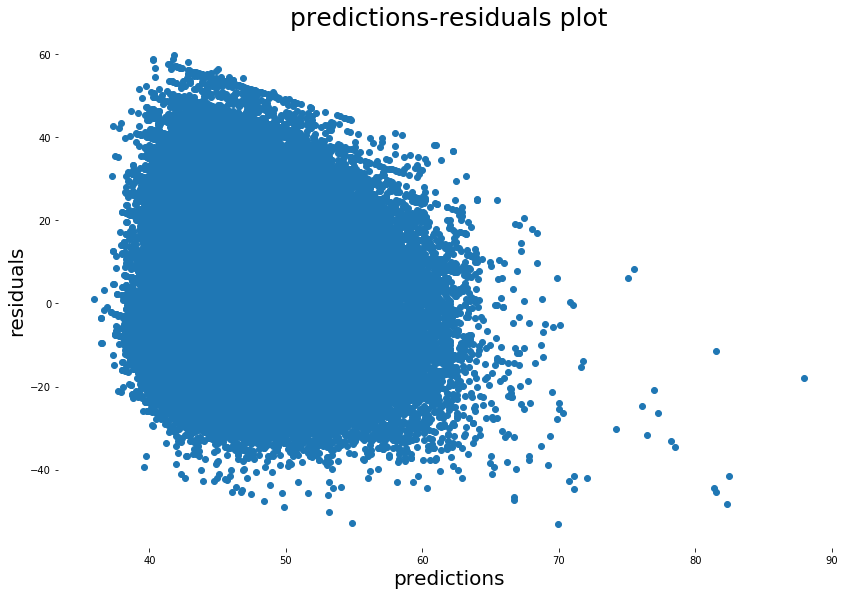

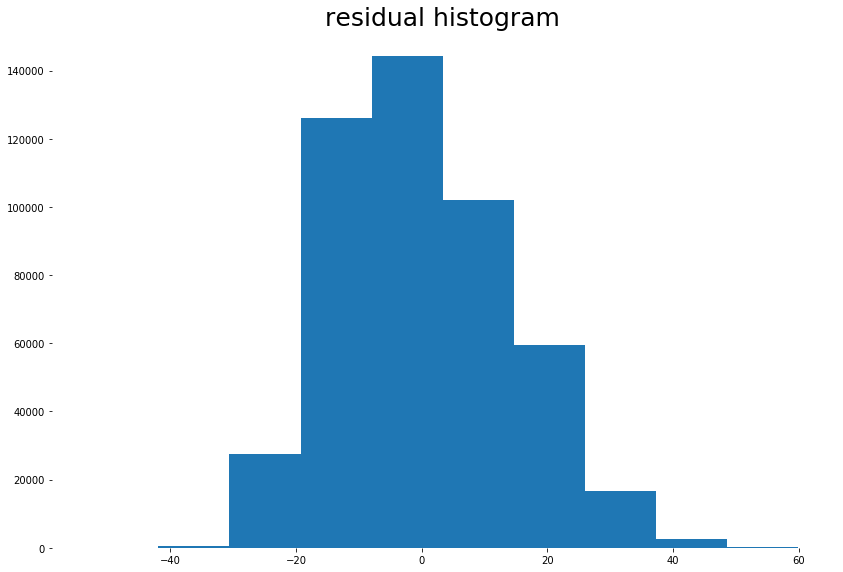

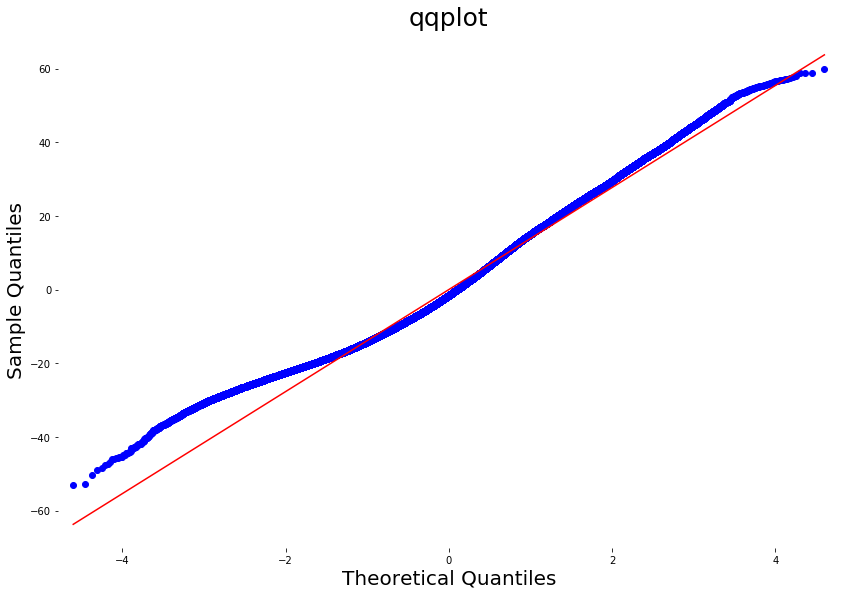

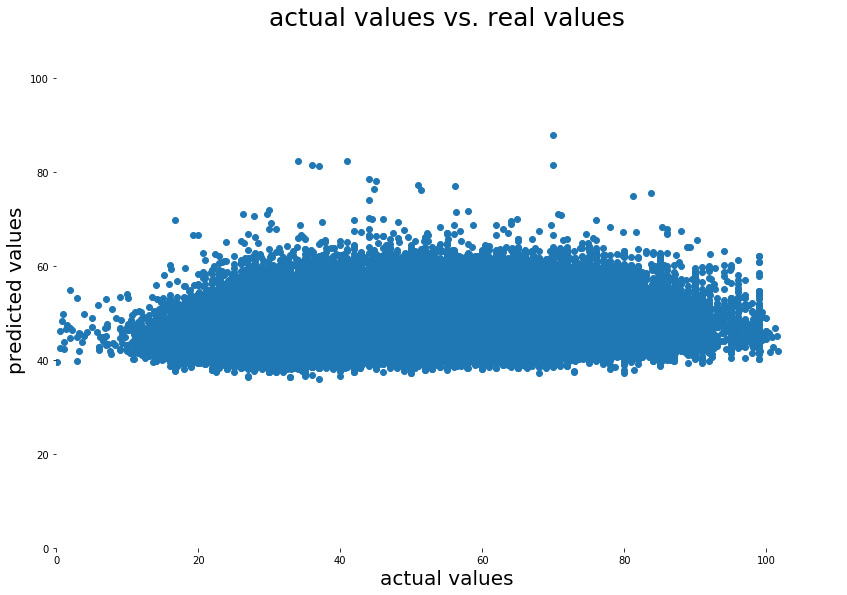

In [27]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump and owner_status
The Mean of the residuals is: 0.00012431507171428623
The Mean Absolute Error is: 11.325293940328665
The pearson's r coefficient between the predictions and actual values is: 0.23566731949584455 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


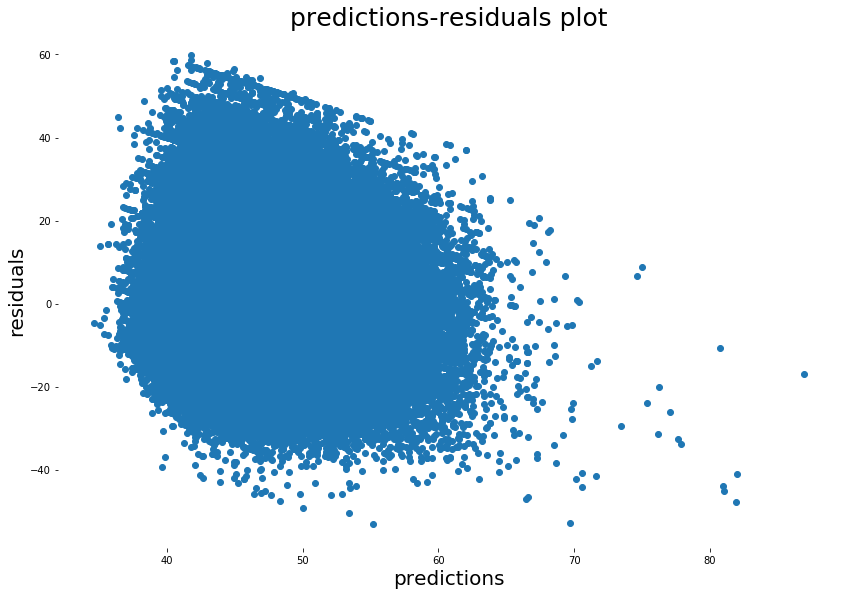

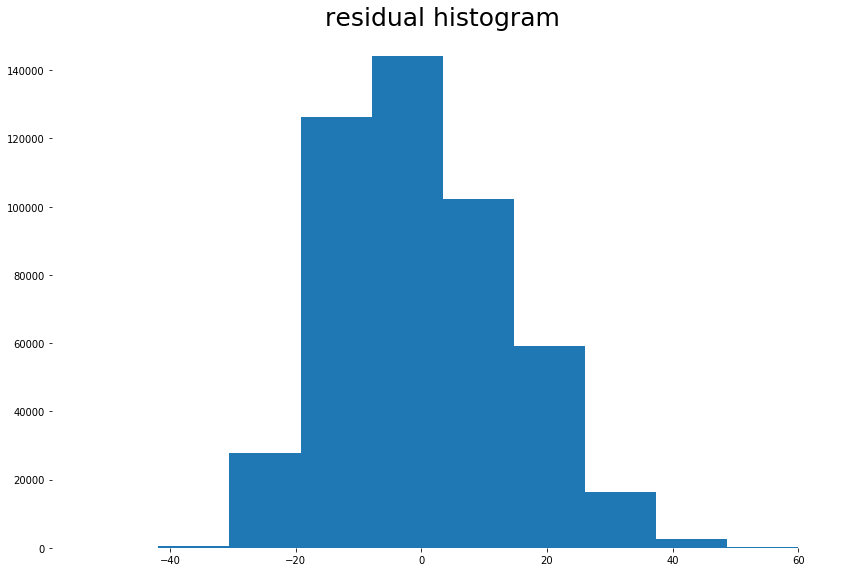

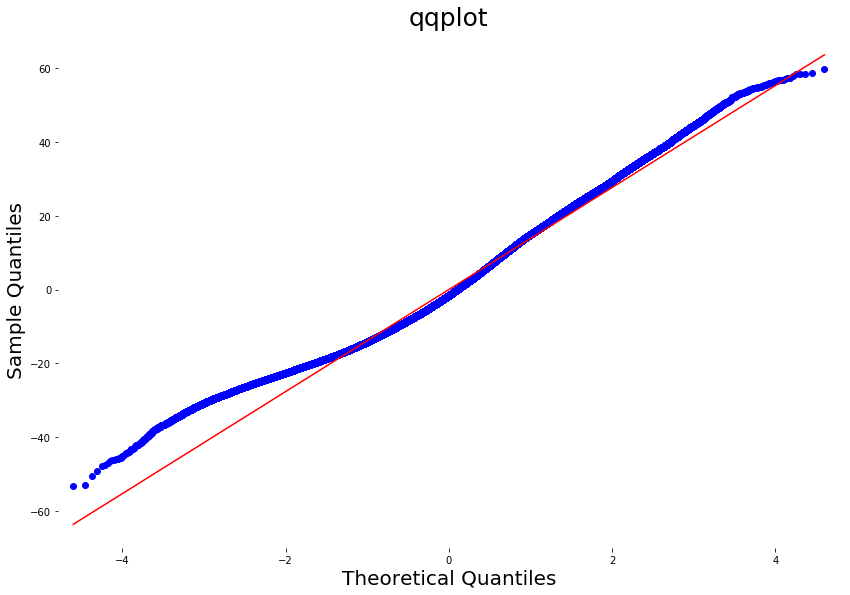

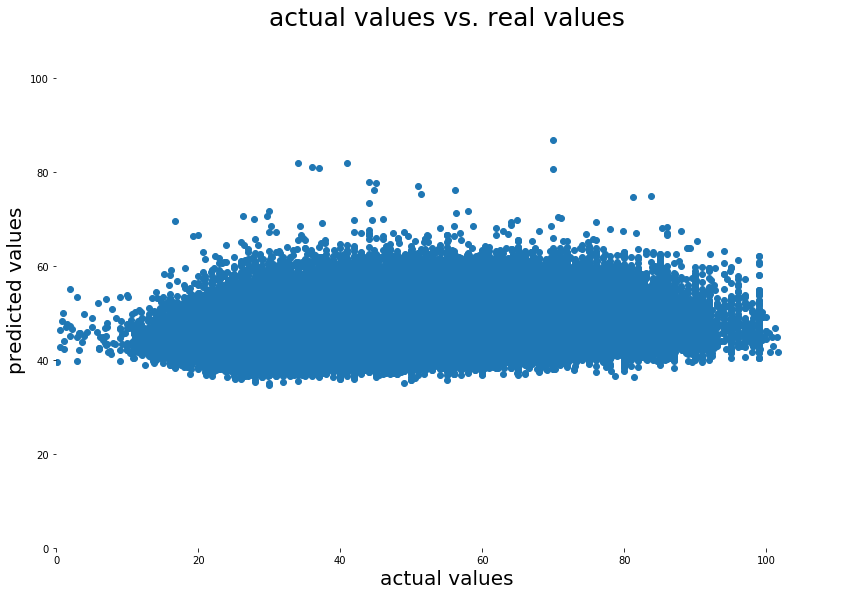

In [28]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status and cart
The Mean of the residuals is: 9.235139751453467e-05
The Mean Absolute Error is: 11.323566517071336
The pearson's r coefficient between the predictions and actual values is: 0.23604707854479523 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


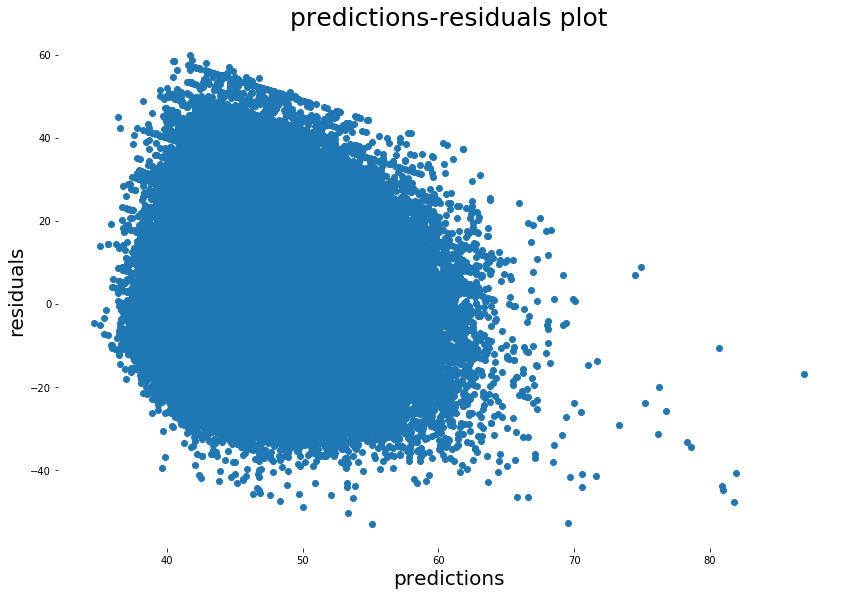

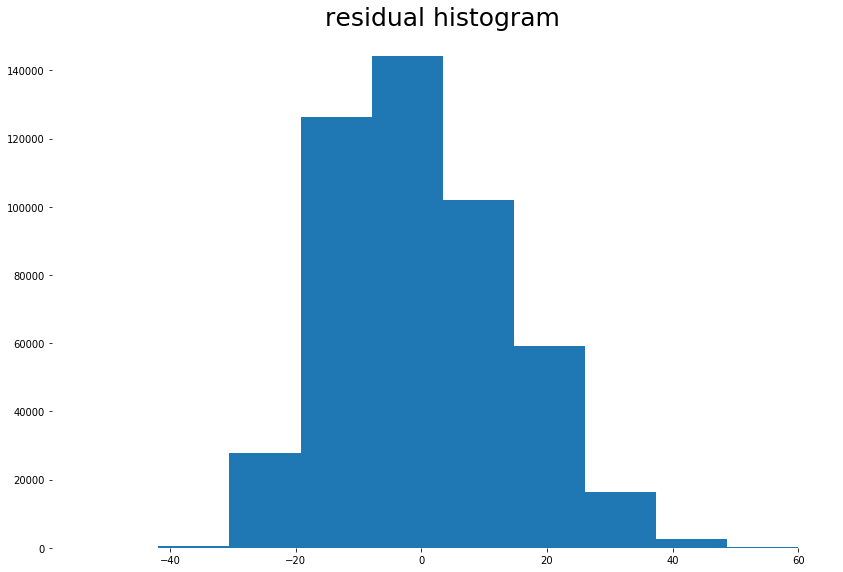

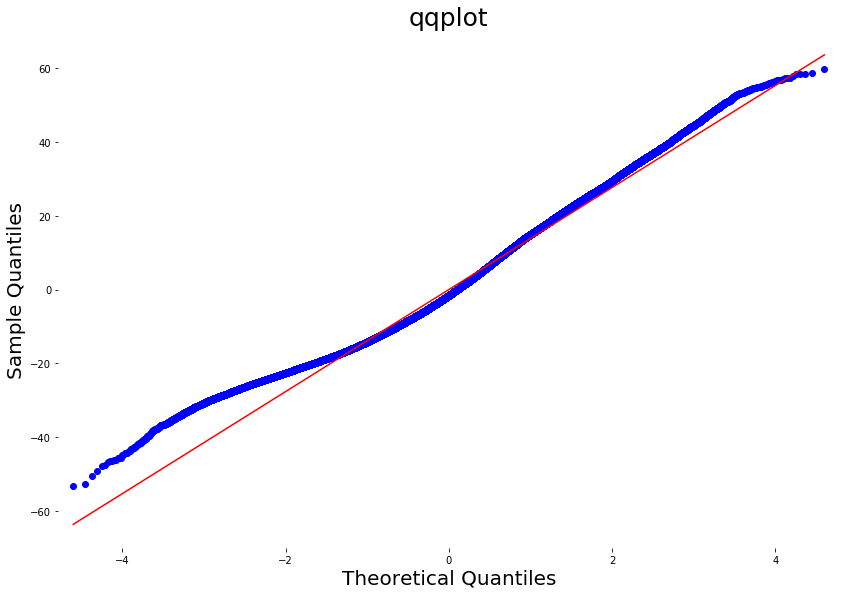

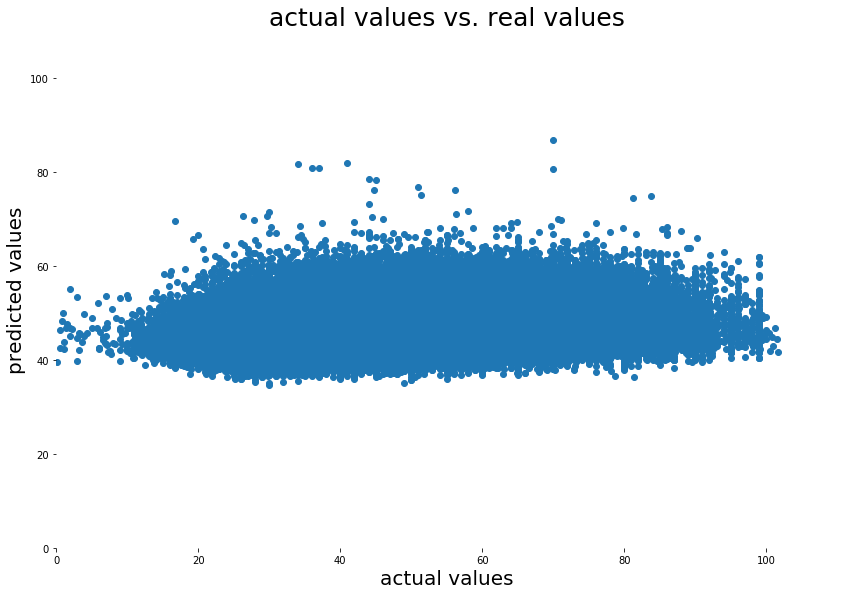

In [29]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart and lighting_source
The Mean of the residuals is: 0.00010828422417143174
The Mean Absolute Error is: 11.322914621019908
The pearson's r coefficient between the predictions and actual values is: 0.23618428377146838 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


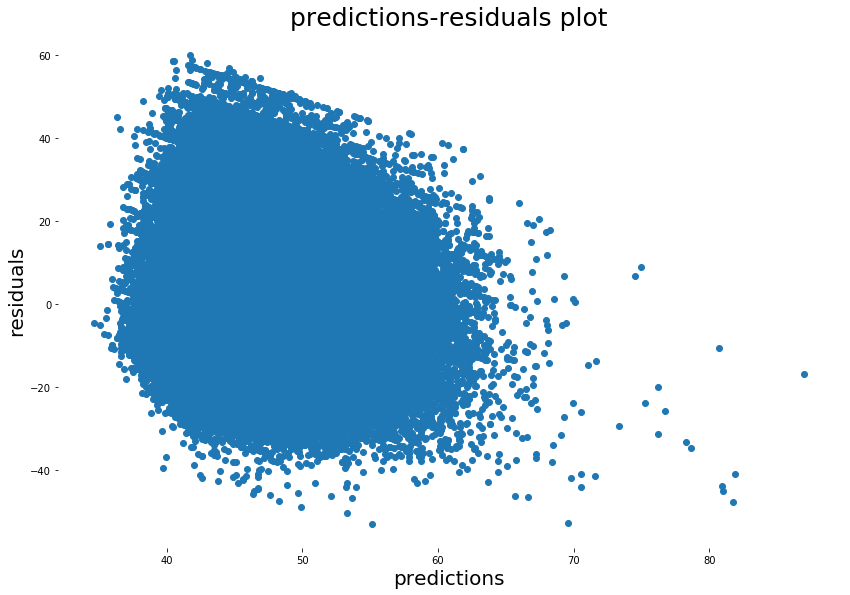

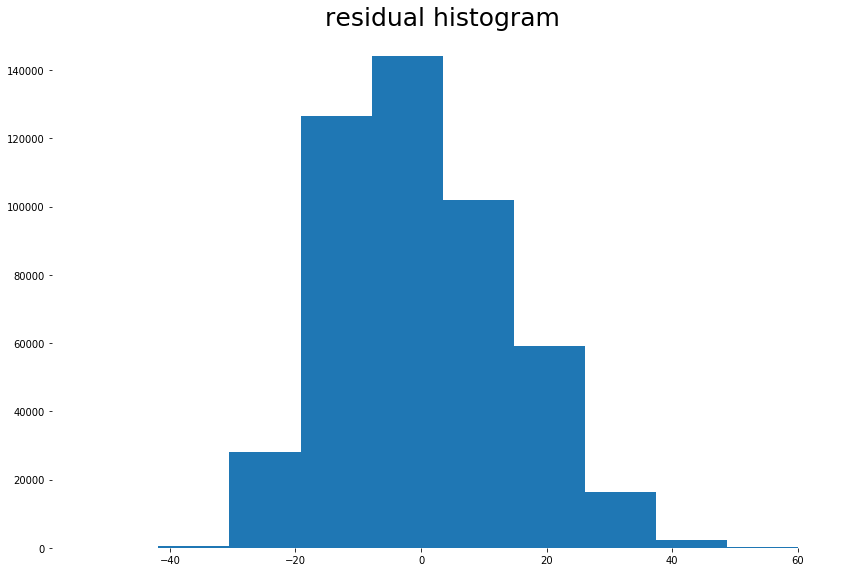

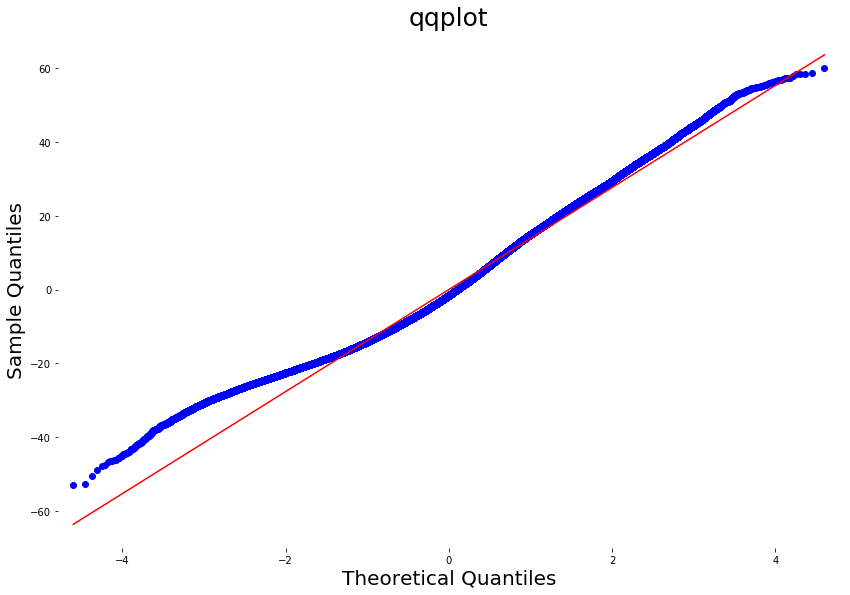

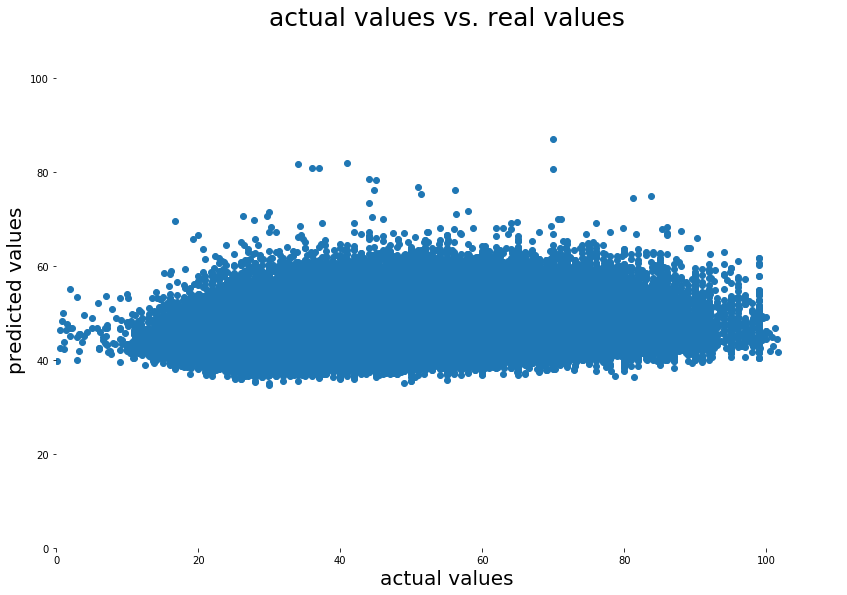

In [30]:
mae_prediction_residual_plot(X_train[make_col_list()])

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source and is_radio
The Mean of the residuals is: 7.831664038567208e-05
The Mean Absolute Error is: 11.322418171987893
The pearson's r coefficient between the predictions and actual values is: 0.23624951346085582 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


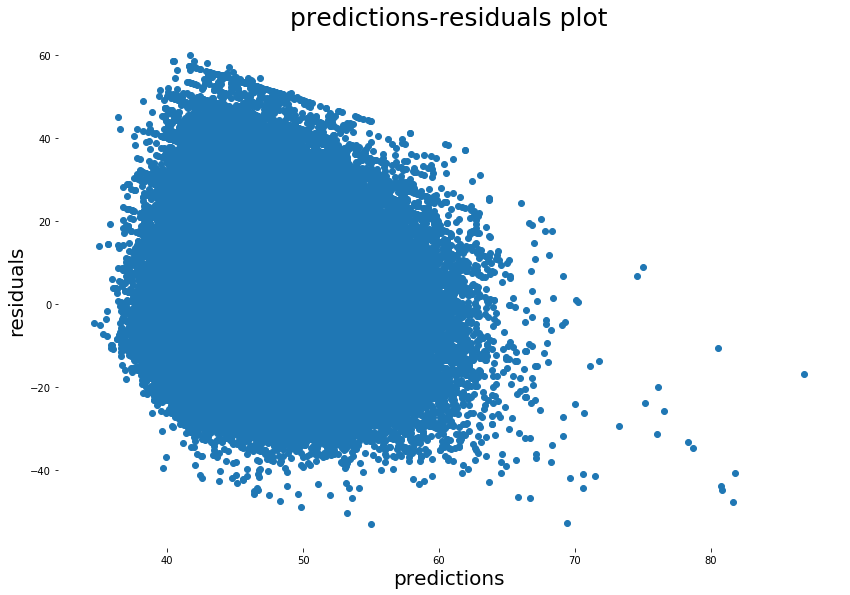

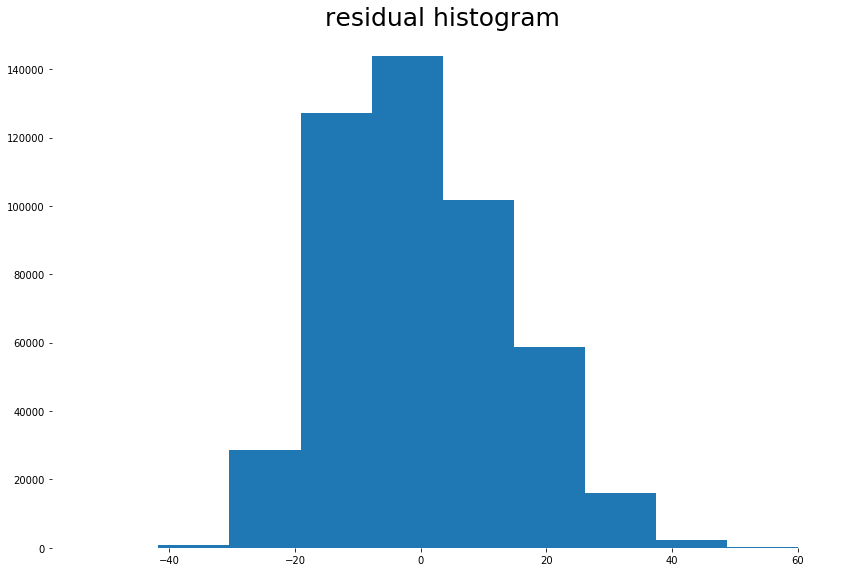

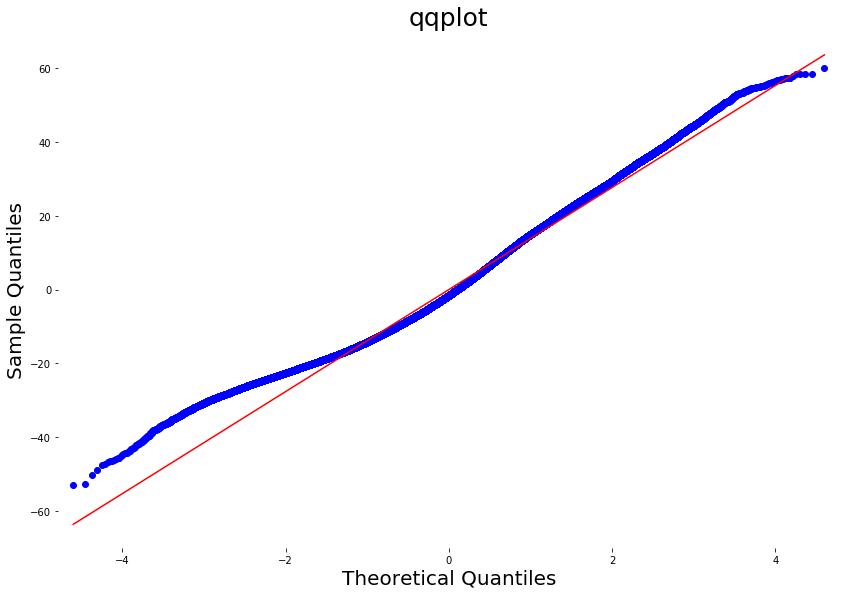

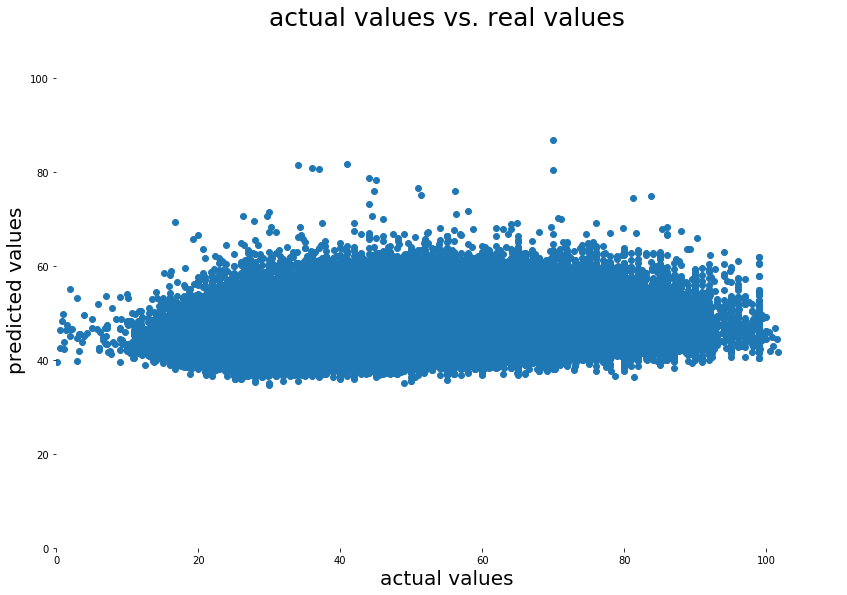

In [31]:
predictions = mae_prediction_residual_plot(X_train[make_col_list()], returns='predictions')

In [32]:
current_col_list

['religion',
 'cooking_fuel',
 'kitchen_availability',
 'is_telephone',
 'is_car',
 'no_of_dwelling_rooms',
 'is_tractor',
 'land_possessed',
 'state',
 'toilet_used',
 'drinking_water_source',
 'is_computer',
 'house_structure',
 'social_group_code',
 'is_water_pump',
 'owner_status',
 'cart',
 'lighting_source',
 'is_radio']

In [33]:
predictions.min()

34.59626551734452

## Conclusions about the best model so far

**There are now no more variables left to add to the model features (excluding those highly associated with those already in the model). We can make the following conclusions from the process above:**

* **Each variable added did minimally improve the Mean Absolute Error. The best model is the one with most feature variables**
* **Even the best model does not perform well. It has a mean absolute error of about 11.322.**
* **The assumptions for linear regression are not met. The predictions-residuals plot shows that there is Heteroscedascidity.**
* **The residuals are not normally distributed. That violates another assumption.**
* **Another proof which shows that the model is rather weak is that there is only a very weak correlation between the actual values and the predictions.**
* **There are no predictions above about 34.6 years and only few above about 70.**
* **The fact that the cross validation score improves when adding more variables to the model and that all predictions are above about 34.6 makes me assume that bias is the main contributor to the bad performance of the model rather than variance. Because the predictors obviously are not too strong but rather not powerful enough, regularized linear regression such as ridge regression or lasso is not an option.**
* **As the residuals are not gaussian, trying out nonparametric regression models in order to figure out whether or not they perform better would be an option. Unfortunately, the power of my hardware makes such models with even a small sample of the data extremely slow. This makes this option impossible.**

## No Intercept

**The scatterplot of predicted and actual values makes me assume that the model might perform better without fitting an intercept. Next I will try this out.**

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source and is_radio
The Mean of the residuals is: 0.01804289752466373
The Mean Absolute Error is: 11.340784151521097
The pearson's r coefficient between the predictions and actual values is: 0.22834475149286362 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


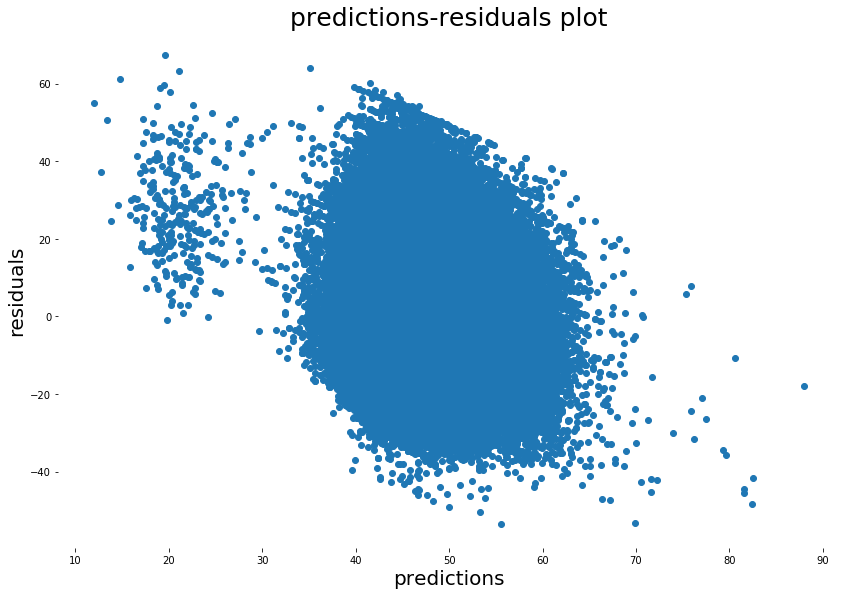

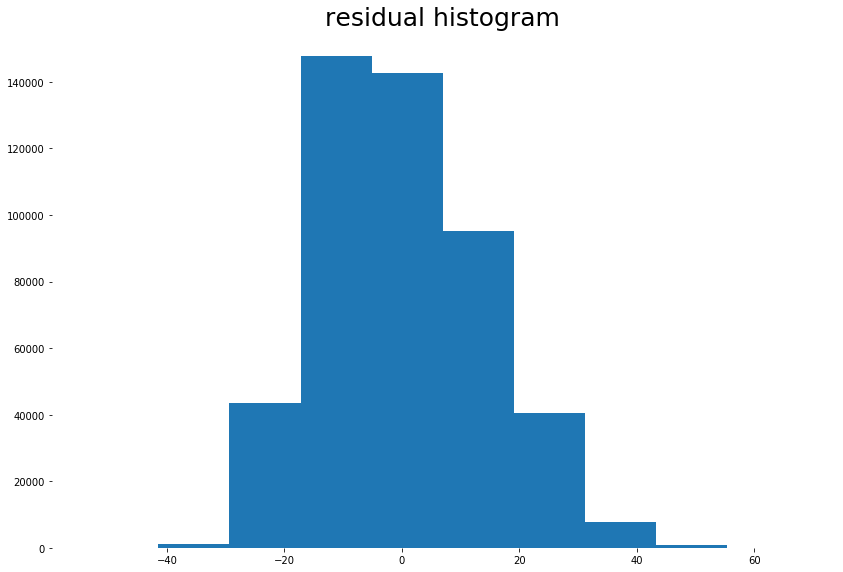

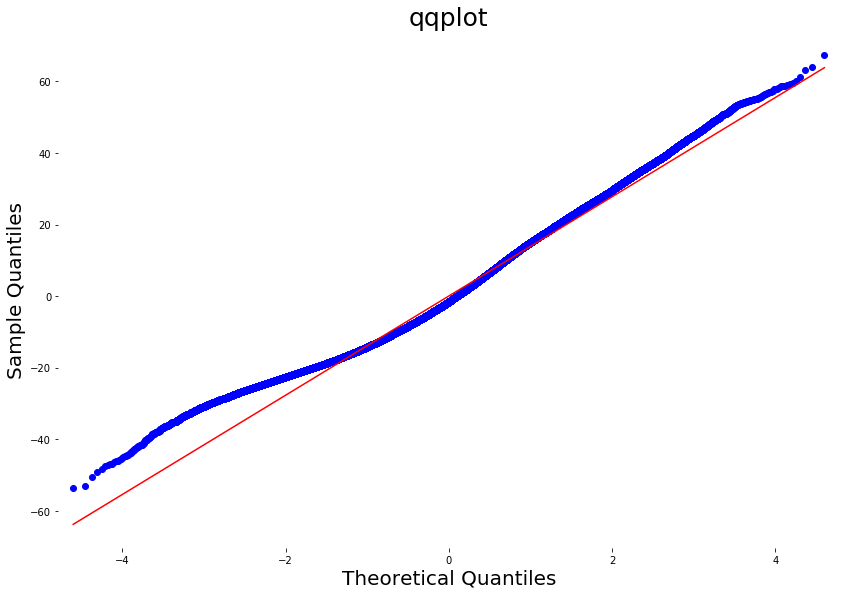

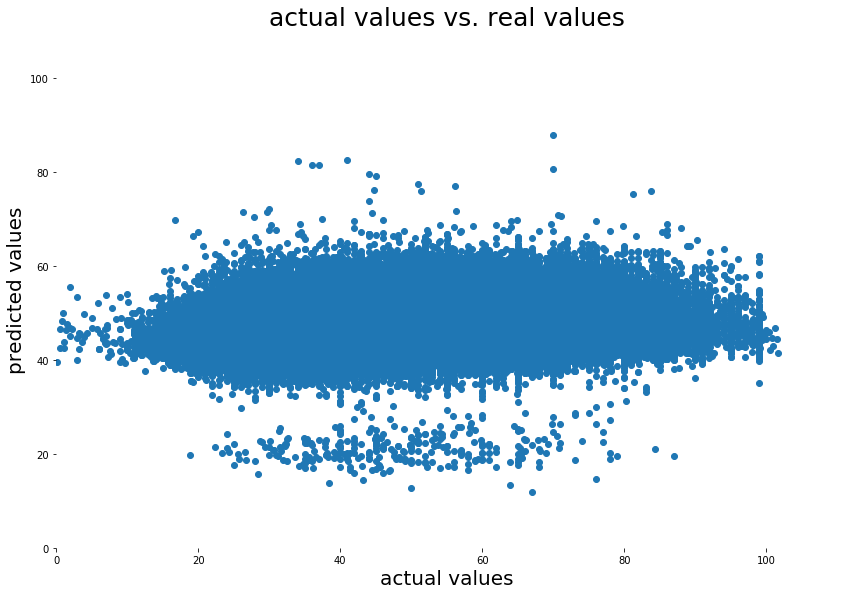

In [34]:
no_intercept_predictions = mae_prediction_residual_plot(X_train[current_col_list], returns='predictions', intercept=False)

## Logarithm

**Leaving out the intercept did indeed strongly increase the range of predicted values - There is an additional cluster now of predicted values between about 10 and 30. The residuals of those values are all positive. Because the mean absolute error is higher than with an intercept I will use the model with an intercept.**

**Perhaps it would help to use the logarithm of the lifetime column. I'll try that out next:**

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source and is_radio
The Mean of the residuals is: 2.089748761086495
The Mean Absolute Error is: 11.263579907768934
The pearson's r coefficient between the predictions and actual values is: 0.23385595385193295 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


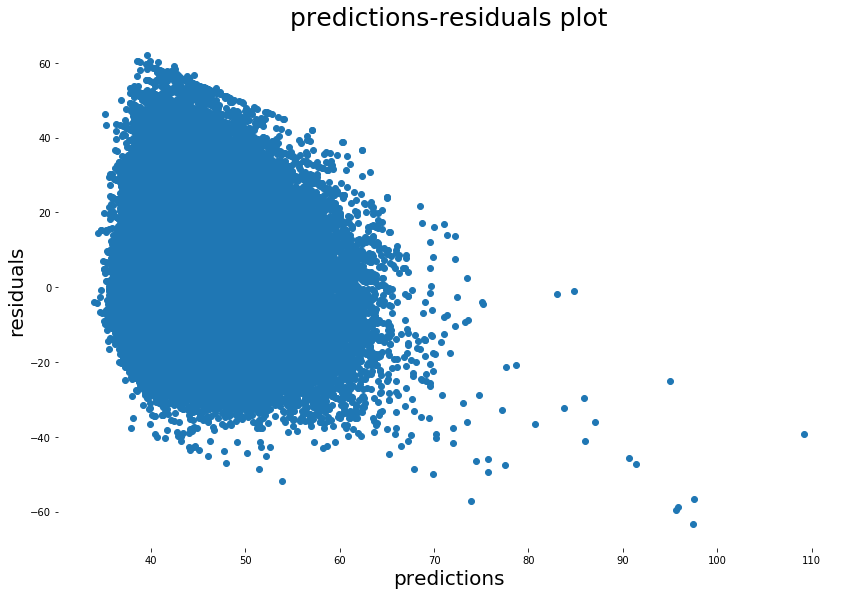

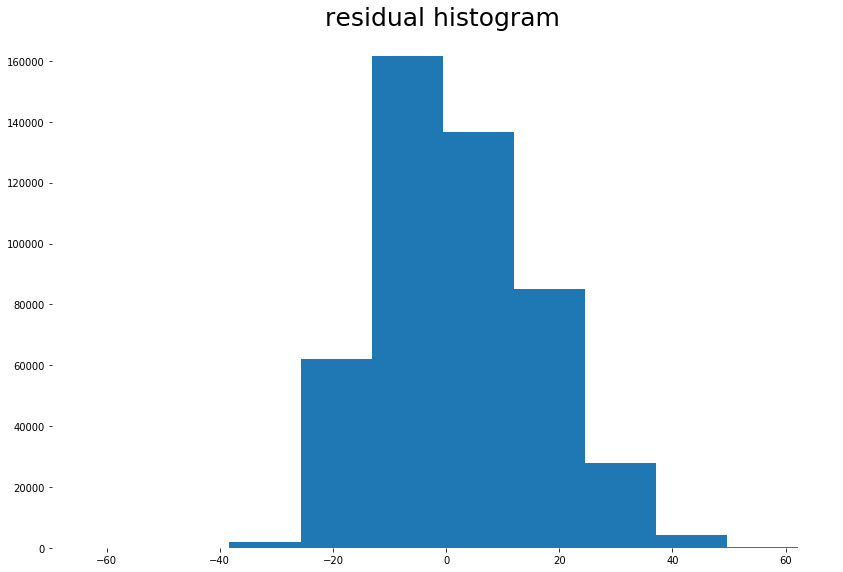

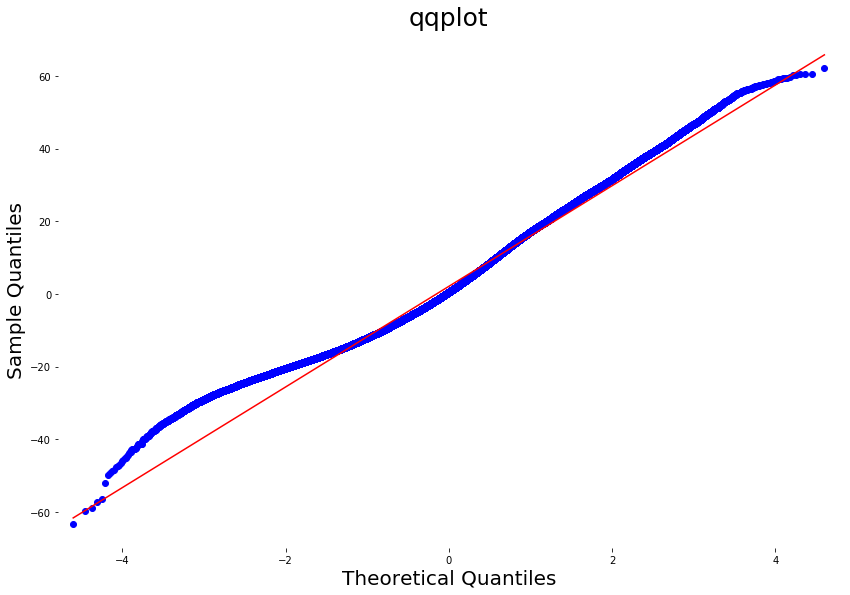

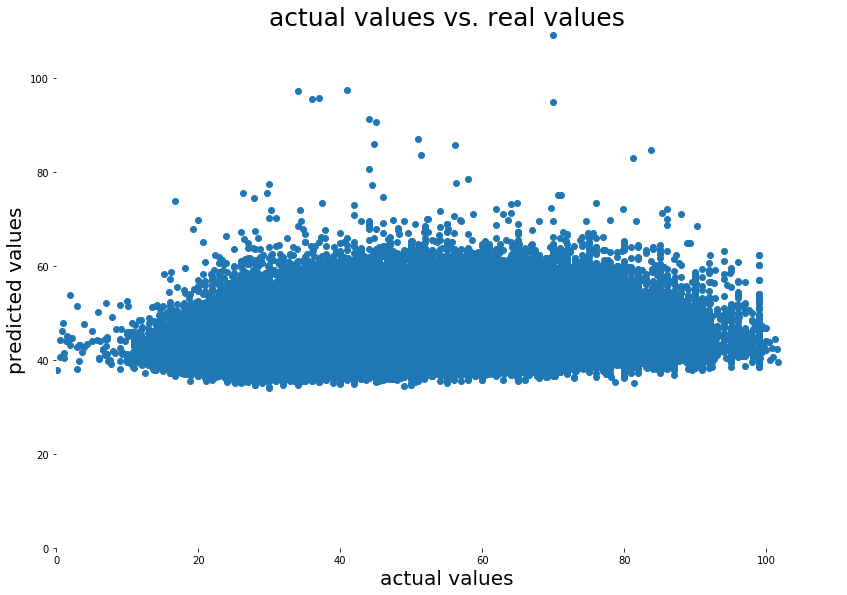

In [35]:
mae_prediction_residual_plot(X_train[current_col_list], log = 'log')

**The mean squared error of this model is slightly better than of the model where we did not take the log of the target column. But because the mean of the residuals is not around 0, I will not use this model. Next I'll plot the so far best model again:**

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source and is_radio
The Mean of the residuals is: 7.831664038567208e-05
The Mean Absolute Error is: 11.322418171987893
The pearson's r coefficient between the predictions and actual values is: 0.23624951346085582 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


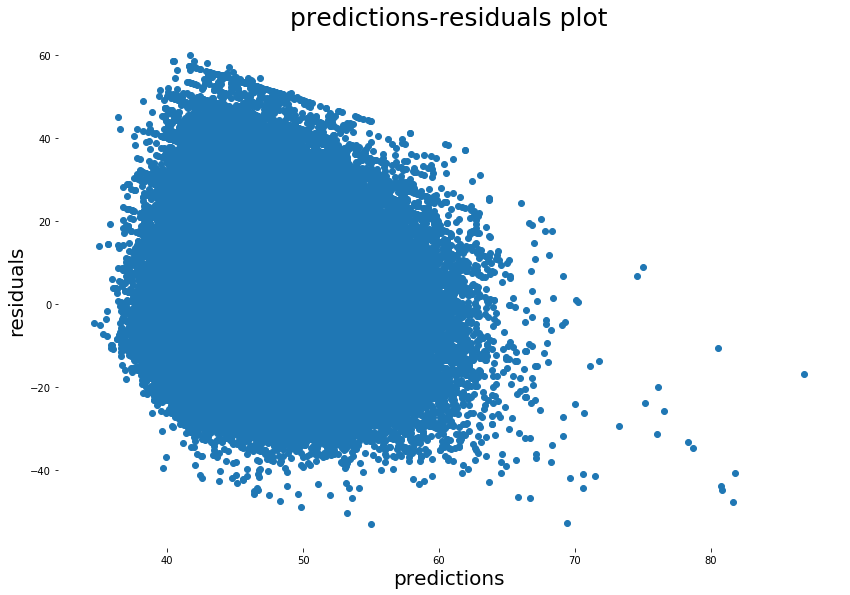

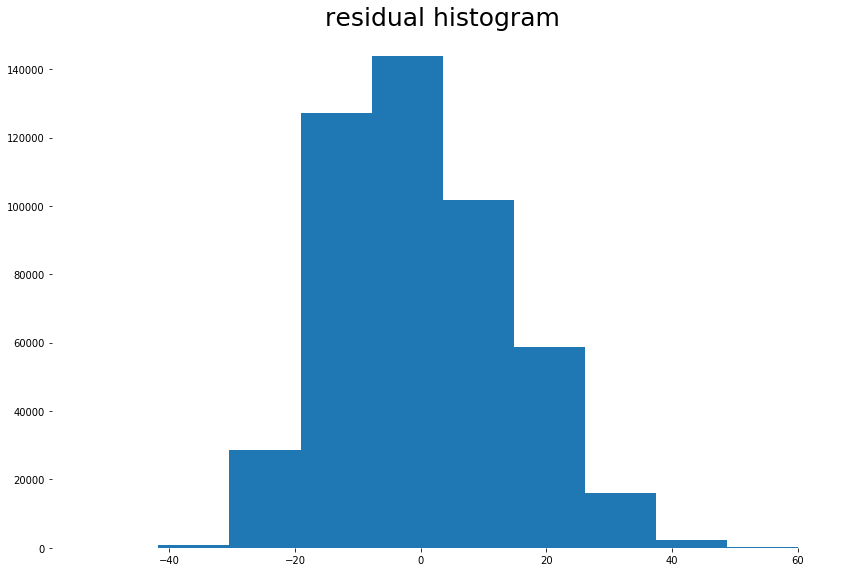

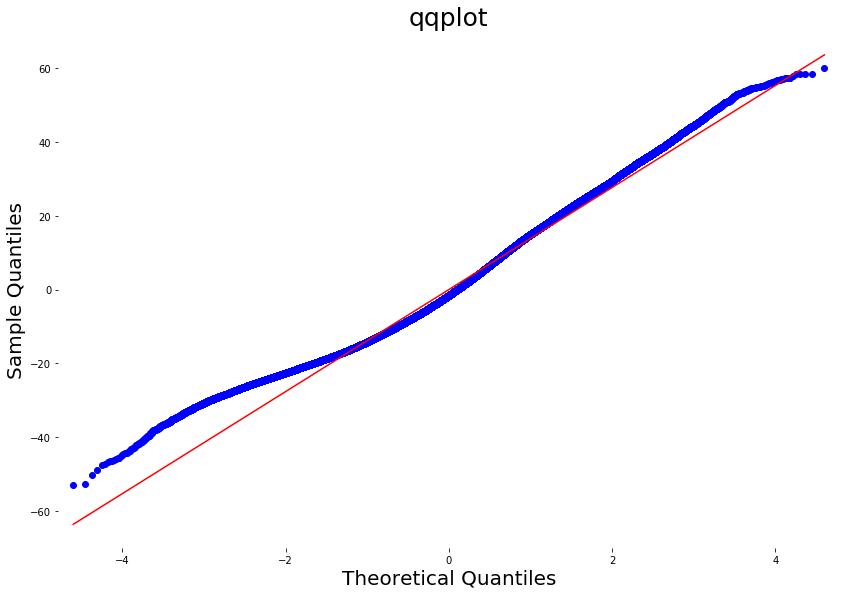

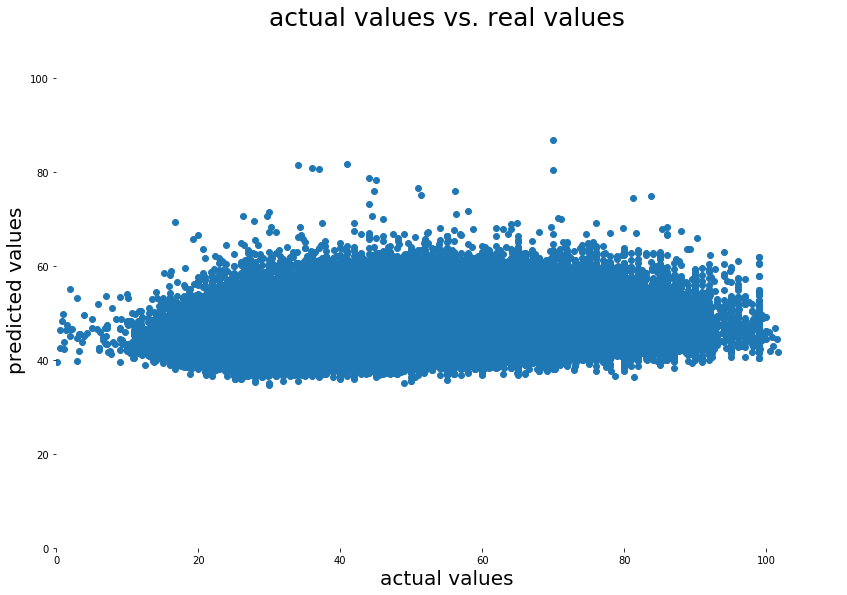

In [54]:
mae_prediction_residual_plot(X_train[current_col_list], savefig=['pred_res.png','res_hist.png','qq.png','act_pred.png'])

## Fitting the whole train set and predicting the test set

**Unfortunately it seems that the data doesn't allow for a more precise prediction (perhaps nonparametric methods would perform better, but my hardware is too weak to perform those in a reasonable timeframe). Therefore I'll now fit the data on the whole training set in order to predict the test set and see how well it performs.**

In [59]:
linreg = LinearRegression()

In [61]:
linreg.fit(make_dummies(X_train[current_col_list]), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [65]:
final_predictions = linreg.predict(make_dummies(X_test[current_col_list]))

In [66]:
final_predictions

array([41.99443746, 43.67255393, 48.03469782, ..., 47.05911425,
       43.37326699, 47.78609723])

In [67]:
final_mae = np.mean(abs(final_predictions-y_test))

In [68]:
final_mae

11.47751922963753

**That the test set MAE is only slightly higher than the one we got by cross validation is another proof for my hypothesis that the problem is rather bias than variance.**

In [75]:
coefficients = pd.DataFrame()

In [76]:
coefficients['Variable'] = make_dummies(X_train[current_col_list]).columns

In [77]:
coefficients['Coefficient'] = linreg.coef_

In [78]:
coefficients_descending = coefficients.sort_values('Coefficient', ascending=False)

In [79]:
coefficients_ascending = coefficients.sort_values('Coefficient', ascending=True)

In [80]:
coefficients_ascending

Variable  Coefficient
4                                     religion_Muslim    -4.805834
6                                     religion_Others    -4.188643
2                                      religion_Hindu    -3.827344
1                                  religion_Christian    -3.618406
7                                       religion_Sikh    -2.251414
61                               social_group_code_ST    -2.235721
12                           cooking_fuel_Electricity    -2.194570
45                        toilet_used_open defecation    -1.924897
44                      toilet_used_To somewhere else    -1.541138
46                        toilet_used_service latrine    -1.455452
29                             land_possessed_No land    -1.440073
20                     is_telephone_Mobile Phone only    -1.424962
64                                owner_status_Rented    -1.082230
21                                    is_telephone_No    -1.036642
60                               social_group_code_SC    -0.981720
39     toilet_used_Open pit /Pit latrine without slab    -0.971187
51  drinking_water_source_Tanker /truck/Cart with ...    -0.952100
42                         toilet_used_To pit latrine    -0.793770
9                  cooking_fuel_Coal/lignite/Charcoal    -0.734667
28                      land_possessed_Less than 0.02    -0.724844
22                        is_telephone_Telephone only    -0.600203
16                            cooking_fuel_No cooking    -0.567253
11                         cooking_fuel_Crop Residue     -0.539381
54                drinking_water_source_other sources    -0.380292
66                             cart_Driven by Machine    -0.377610
40                  toilet_used_Pit latrine with slab    -0.364941
13                              cooking_fuel_Firewood    -0.316188
18        kitchen_availability_Does not have kitchen     -0.290953
41  toilet_used_Pit latrine(without flush/ pour fl...    -0.282708
14                              cooking_fuel_Kerosene    -0.112780
43                         toilet_used_To septic tank    -0.098529
10                        cooking_fuel_Cow dung cake     -0.091914
49         drinking_water_source_Public tap/standpipe    -0.030802
3                                       religion_Jain    -0.026146
55               is_computer_With Internet connection     0.054874
67                                         cart_Other     0.157633
53         drinking_water_source_Unprotected dug well     0.171902
15                              cooking_fuel_LPG/PNG      0.187641
59                        house_structure_Semi Pucca      0.220330
73                                       is_radio_Yes     0.221420
56            is_computer_Without Internet connection     0.270414
38  toilet_used_Flush/Pour flush latrine connected...     0.275783
52       drinking_water_source_Tube well or Borehole      0.352978
50                drinking_water_source_Surface water     0.357211
17  kitchen_availability_Cooking outside house:Has...     0.397544
24                                     is_tractor_Yes     0.437899
57                            house_structure_Others      0.438896
48           drinking_water_source_Protected dug well     0.468729
62                                  is_water_pump_Yes     0.493974
58                             house_structure_Pucca      0.564839
23                                         is_car_Yes     0.707777
47  drinking_water_source_Piped water into dwellin...     0.831459
25              land_possessed_1.00 to less than 4.00     0.840602
72                             lighting_source_Solar      0.861120
71                         lighting_source_Other Oils     0.913060
8                                 cooking_fuel_Biogas     0.933086
26                       land_possessed_10.00 or more     0.943232
65                              cart_Driven by Animal     0.954902
27             land_possessed_4.00 to less than 10.00     1.064737
69                       

In [81]:
coefficients_descending

Variable  Coefficient
0                                no_of_dwelling_rooms    45.573364
19                    kitchen_availability_No cooking     5.398230
5                                religion_No religion     4.275222
34                                       state_Odisha     3.167353
37                                  state_Uttarakhand     3.110424
70                        lighting_source_No lighting     2.948599
36                                state_Uttar Pradesh     2.931882
30                                        state_Bihar     2.673856
63                                 owner_status_Owned     2.111630
33                               state_Madhya Pradesh     1.943479
32                                    state_Jharkhand     1.875356
31                                 state_Chhattisgarh     1.558776
35                                    state_Rajasthan     1.525703
68                        lighting_source_Electricity     1.269960
69                           lighting_source_Kerosene     1.146444
27             land_possessed_4.00 to less than 10.00     1.064737
65                              cart_Driven by Animal     0.954902
26                       land_possessed_10.00 or more     0.943232
8                                 cooking_fuel_Biogas     0.933086
71                         lighting_source_Other Oils     0.913060
72                             lighting_source_Solar      0.861120
25              land_possessed_1.00 to less than 4.00     0.840602
47  drinking_water_source_Piped water into dwellin...     0.831459
23                                         is_car_Yes     0.707777
58                             house_structure_Pucca      0.564839
62                                  is_water_pump_Yes     0.493974
48           drinking_water_source_Protected dug well     0.468729
57                            house_structure_Others      0.438896
24                                     is_tractor_Yes     0.437899
17  kitchen_availability_Cooking outside house:Has...     0.397544
50                drinking_water_source_Surface water     0.357211
52       drinking_water_source_Tube well or Borehole      0.352978
38  toilet_used_Flush/Pour flush latrine connected...     0.275783
56            is_computer_Without Internet connection     0.270414
73                                       is_radio_Yes     0.221420
59                        house_structure_Semi Pucca      0.220330
15                              cooking_fuel_LPG/PNG      0.187641
53         drinking_water_source_Unprotected dug well     0.171902
67                                         cart_Other     0.157633
55               is_computer_With Internet connection     0.054874
3                                       religion_Jain    -0.026146
49         drinking_water_source_Public tap/standpipe    -0.030802
10                        cooking_fuel_Cow dung cake     -0.091914
43                         toilet_used_To septic tank    -0.098529
14                              cooking_fuel_Kerosene    -0.112780
41  toilet_used_Pit latrine(without flush/ pour fl...    -0.282708
18        kitchen_availability_Does not have kitchen     -0.290953
13                              cooking_fuel_Firewood    -0.316188
40                  toilet_used_Pit latrine with slab    -0.364941
66                             cart_Driven by Machine    -0.377610
54                drinking_water_source_other sources    -0.380292
11                         cooking_fuel_Crop Residue     -0.539381
16                            cooking_fuel_No cooking    -0.567253
22                        is_telephone_Telephone only    -0.600203
28                      land_possessed_Less than 0.02    -0.724844
9                  cooking_fuel_Coal/lignite/Charcoal    -0.734667
42                         toilet_used_To pit latrine    -0.793770
51  drinking_water_source_Tanker /truck/Cart with ...    -0.952100
39     toilet_used_Open pit /Pit latrine without slab    -0.971187
60                       

## Recommendations

**The final Mean Absolute Error is about 11.43 years. This is rather high, but perhaps the data at hand doesn't allow for a better score. I would make the following recommendations:**

1. **As the Mean Absolute Error is rather high I would be very cautious about using this model. It can however be used for a getting a first intuition when searching for households with a high or low life expectancies or when assessing the life expectancy of members of a certain group of households.**
2. **For finding households with high life expectancies it might also be helpfull to look at the ordered coefficient DataFrames I provided above. When searching for households where members have a high life expectancy one could search for example for households that have a high number of dwelling rooms, do not cook thelselves, do not follow a religion or live in certain districts. When searching for households with a low life expectancy one could search for example for religious household members, especially muslims, households that use electricity for cooking, households in which members defacate openly and households without land.**
3. **I assume that the model would perform far better if I wouldn't have had to delete all variables connected to the deceased themselves (as oposed to about their households). Some of those variables I believe could be quite strong predictors, for example whether or not a person smokes. The reason I had to delete those variables is that the survey was performed in a wrong way for this task - all rows are about the state of the deceased at the exact time he or she died. My recommendation is to put up a new survey in a way that would allow me not to delete the variables about the deceased himself or herself. In order to do so instead of asking members of the household about the deceased, living people should be interviewed and the information about the life expectancy should be added once they'll have died. Those people should be either interview all at the same age or at a random age.**

**This was the main part of this project. Additionally I will readd all variables I've deleted due to being about the deceased individual and not about his or her household to the project. It is important to note that this new model I'll build won't be useful for use of new unseen data for reasons I've already explained. This new model also won't be useful to determine which of the readded variables are useful for predicting the life expectancy of a person. This new model will merely be an experiment that can serve to get a sense of how the model COULD perform with more variables. This in turn can be an argument for or against the execution of the third recommendation, but shouldn't be the only factor to take into account for making this decision. "Part 2" will be this experimental linear regression.**

# Part 2 - Experimental linear regression

In [82]:
with open('new_indians.pickle','rb') as f:
    new_X_train, new_X_test, new_y_train, new_y_test = pickle.load(f)

In [83]:
with open('asspairs_diffo.pickle','rb') as f:
    association_pairs_dict, difference_order = pickle.load(f)

In [85]:
col_difference_order = list(difference_order.index)

I will now step by step add more variables to the model, leaving variables out in case there are already strongly associated variables.

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source, is_radio and occupation_status
The Mean of the residuals is: -5.402985647200624e-05
The Mean Absolute Error is: 9.832397342655662
The pearson's r coefficient between the predictions and actual values is: 0.5196118476760687 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


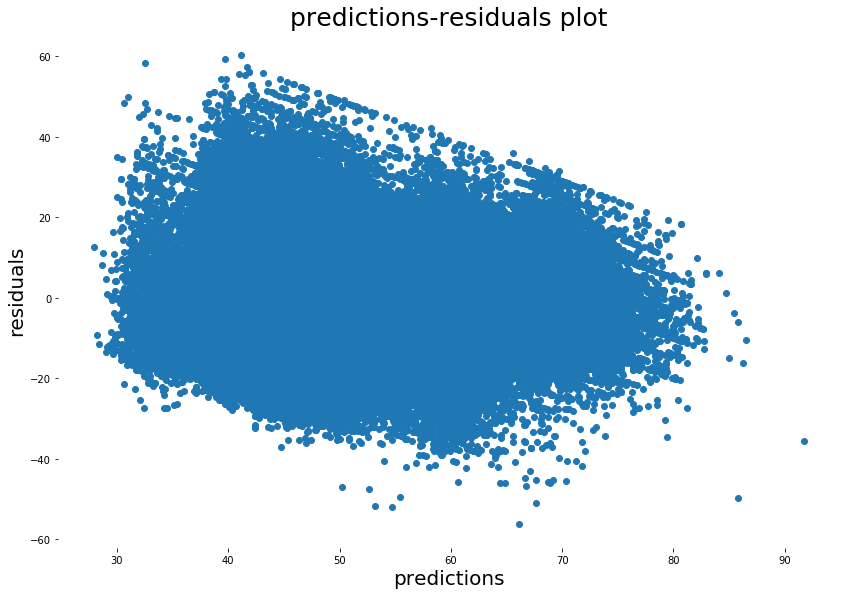

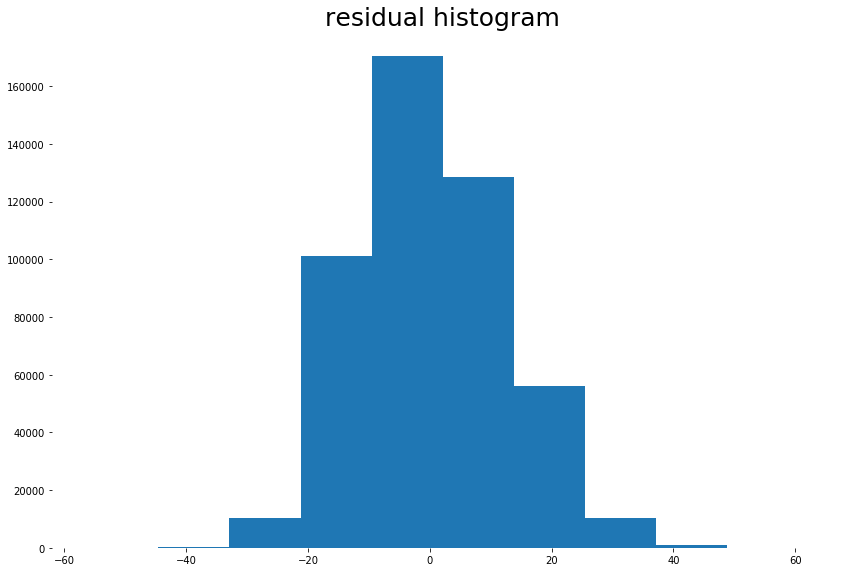

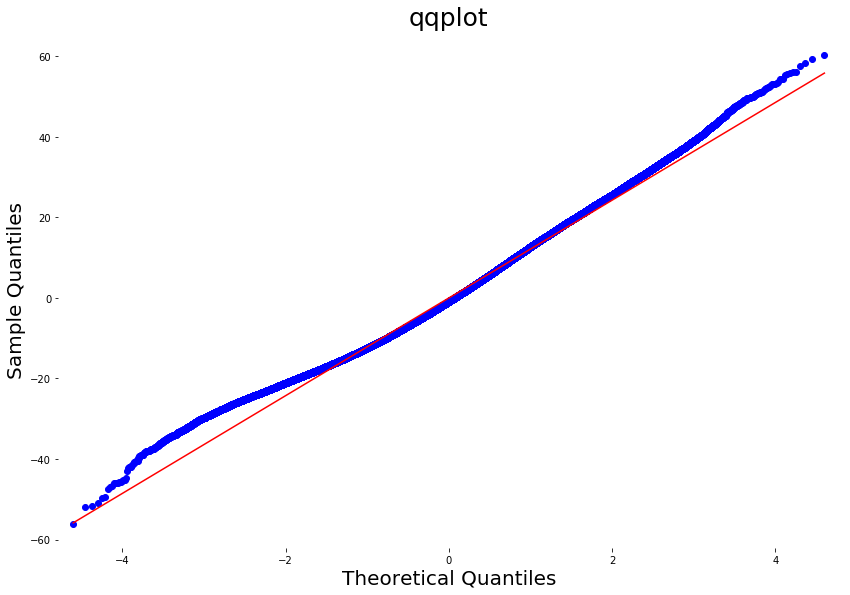

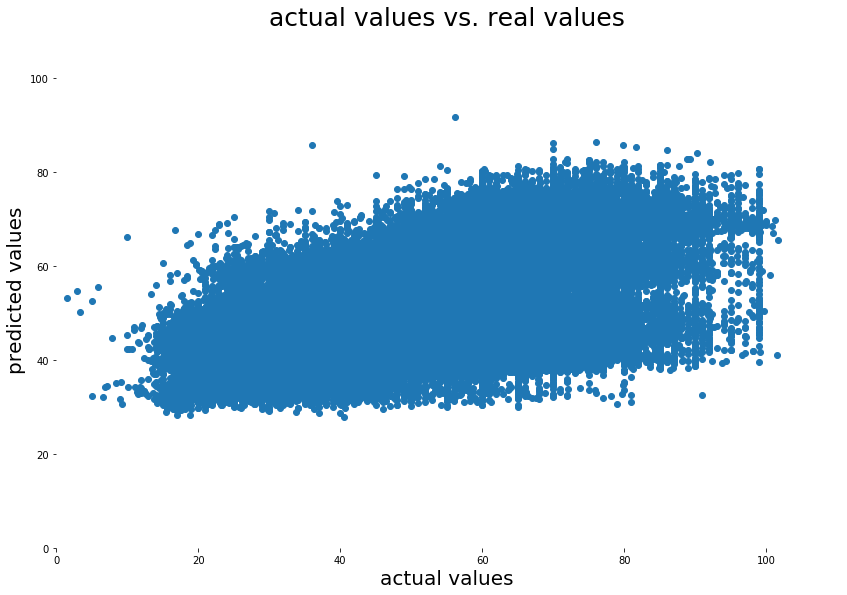

In [86]:
mae_prediction_residual_plot(new_X_train[make_col_list()], y_train=new_y_train)

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source, is_radio, occupation_status and marital_status
The Mean of the residuals is: -3.315911511333917e-05
The Mean Absolute Error is: 9.464561485878916
The pearson's r coefficient between the predictions and actual values is: 0.5674055182566176 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


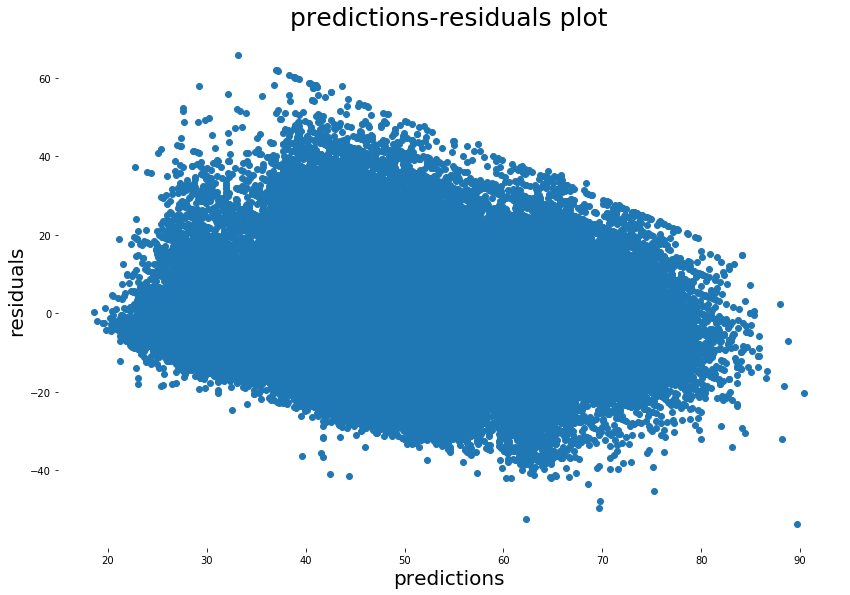

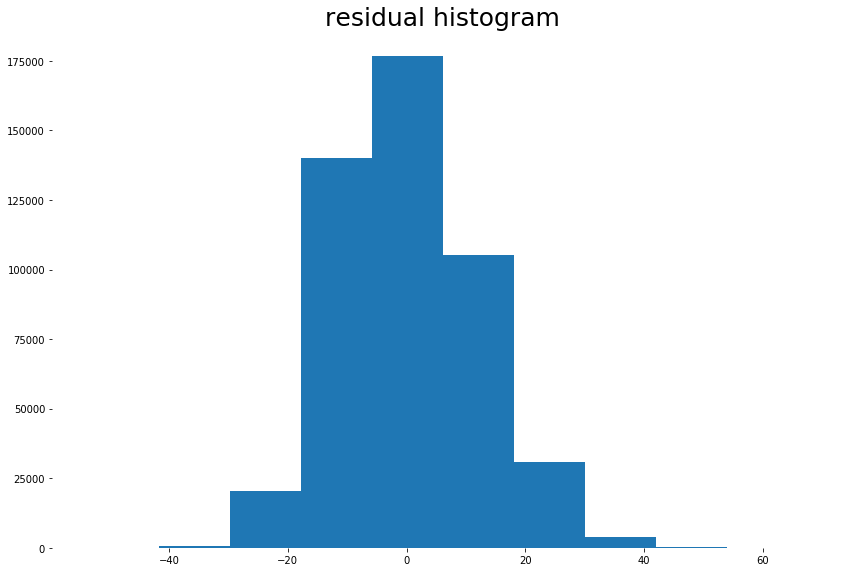

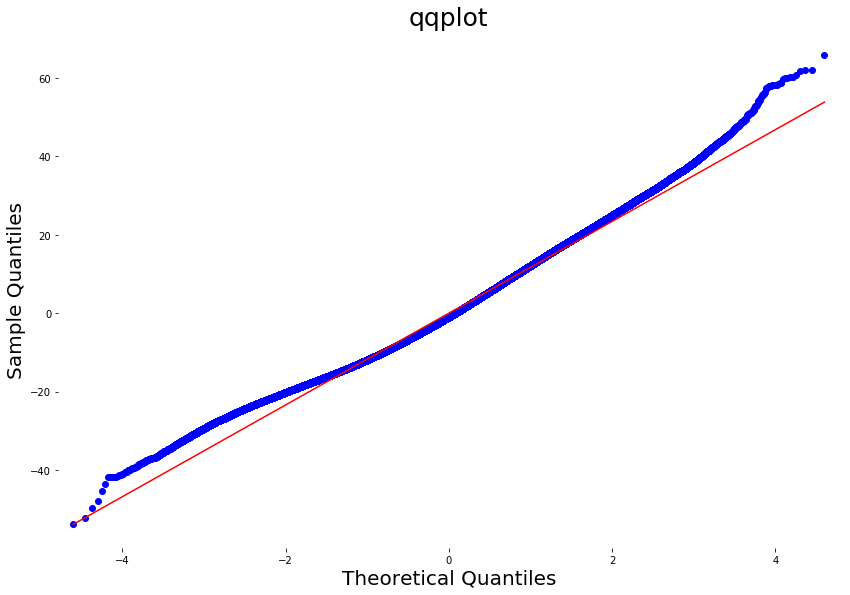

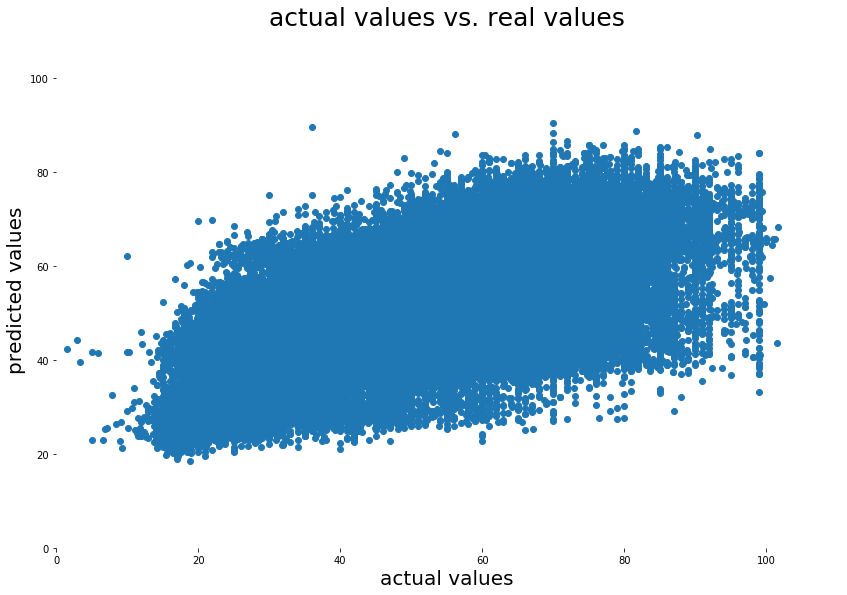

In [87]:
mae_prediction_residual_plot(new_X_train[make_col_list()], y_train=new_y_train)

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source, is_radio, occupation_status, marital_status and disability_status
The Mean of the residuals is: 4.566437140982088e-05
The Mean Absolute Error is: 9.446589579964602
The pearson's r coefficient between the predictions and actual values is: 0.5695240855174196 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


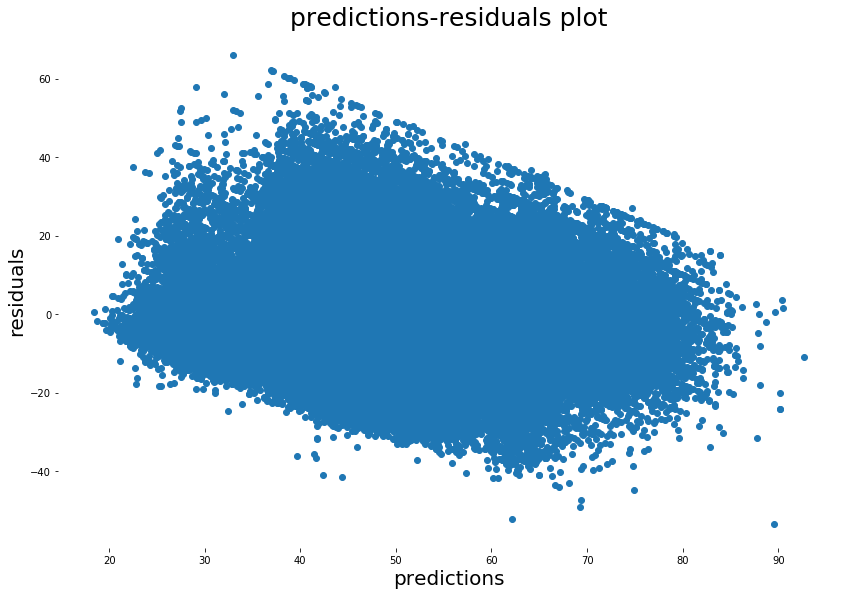

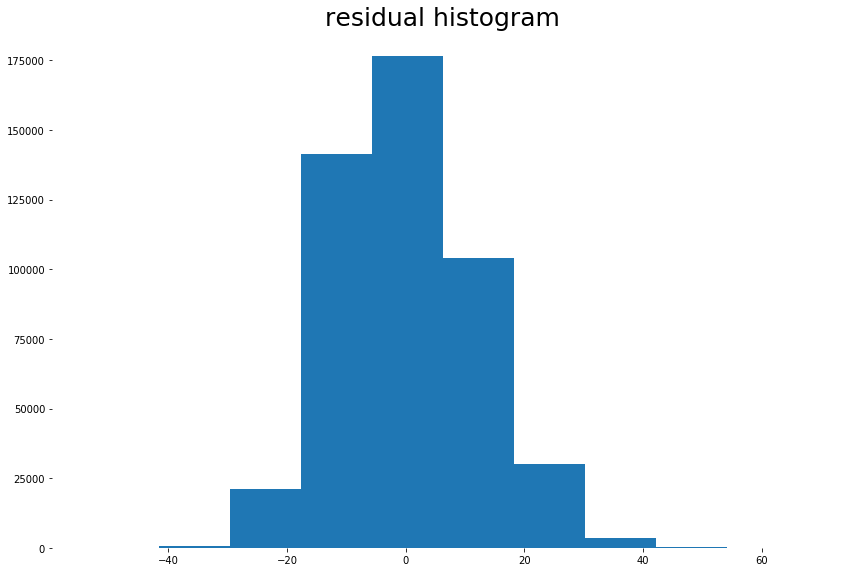

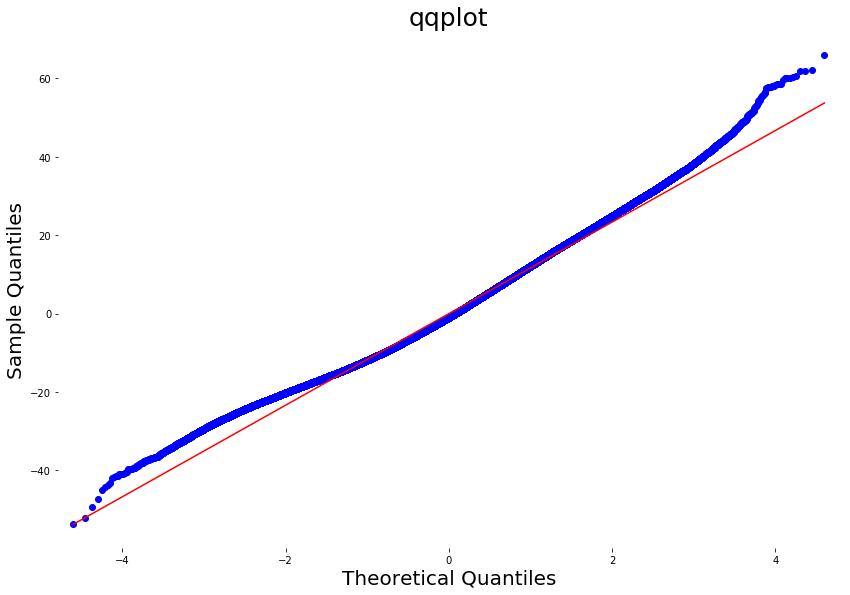

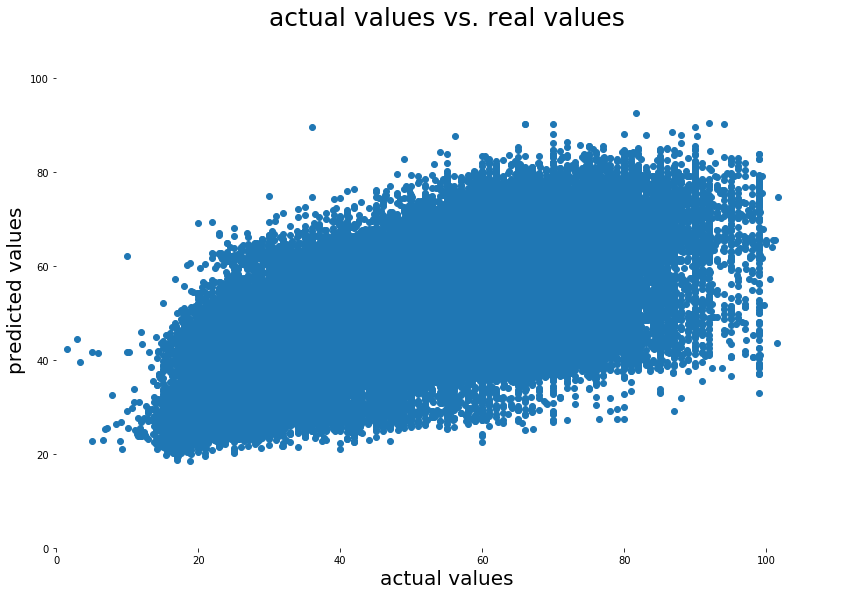

In [88]:
mae_prediction_residual_plot(new_X_train[make_col_list()], y_train=new_y_train)

/home/florian/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The one-hot encoded variables used are: religion, cooking_fuel, kitchen_availability, is_telephone, is_car, no_of_dwelling_rooms, is_tractor, land_possessed, state, toilet_used, drinking_water_source, is_computer, house_structure, social_group_code, is_water_pump, owner_status, cart, lighting_source, is_radio, occupation_status, marital_status, disability_status and smoke
The Mean of the residuals is: 2.15687396567595e-05
The Mean Absolute Error is: 9.376573893804533
The pearson's r coefficient between the predictions and actual values is: 0.5767010274304722 and the p value for testing non-correlation is: 0.0
The p value of the D'Agostino & Pearson normality test is (Null-Hypothesis: residuals are normal) : 0.0


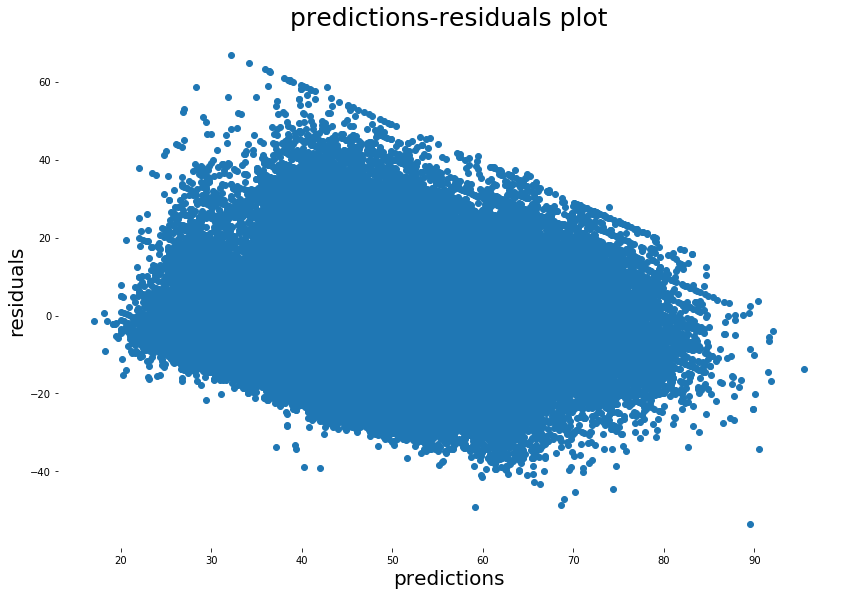

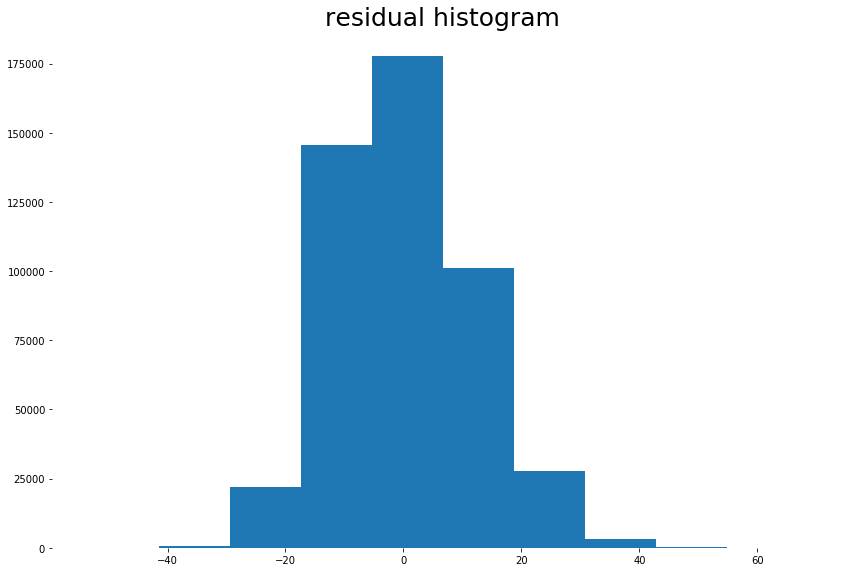

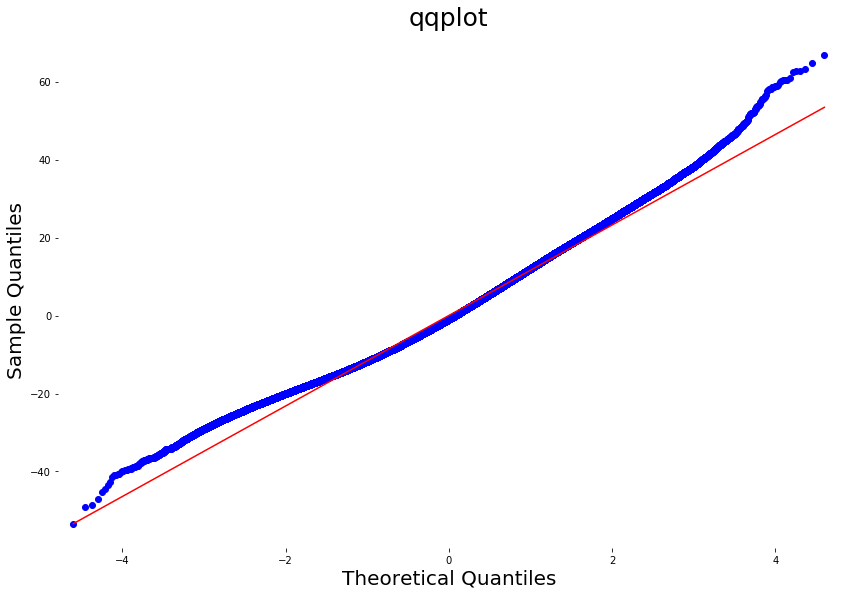

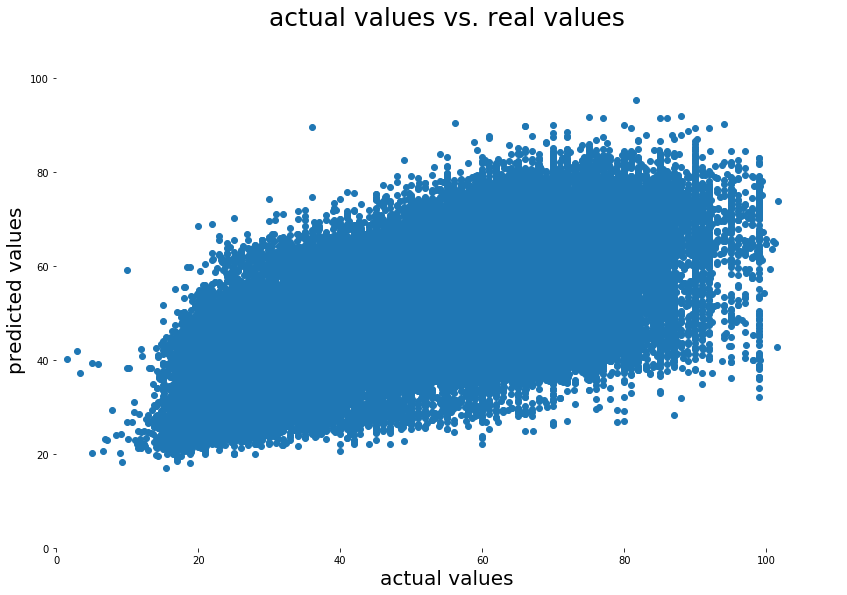

In [90]:
predictions = mae_prediction_residual_plot(new_X_train[make_col_list()], y_train=new_y_train, savefig=['new_pred_res.png','new_res_hist.png','new_qq.png','new_act_pred.png'])

**If we compare the best model we've got using the original data with this experimental model using the personal variables about the deceased as well, we can find the following differences:**

* **In terms of Mean Absolute Error, the new experimental model performs better than the old 'real' model. The difference is about 2 years.**
* **There is far less Heteroscedascidity in the new experimental model.**
* **The correlation between actual and predicted values is still not very strong with the new experimental model, but far stronger than in the old 'real' one.**

**All in all this model performed far better, except for the fact that the residuals are still not gaussian. But what can we conclude from this? We can not use this new model on unseen real data. But it gives as a hint that by adding more variables the "real" model might perform better. This is an argument for resurveying in a way that allows us to use data about the individuals.**